# Generating Wills Dataset

Here i am developing code to generate the 100 datasets will has requested.

## Utility Functions 

Below is the code i am developing to generate perturbed models from dyngen.

In [1]:
library(dyno)
library(scran)
library(scater)
library(slurmR)
library(dyngen)
library(igraph)
library(DESeq2)
library(parallel)
library(dynutils)
library(tidyverse)
library(countsimQC)
library(assertthat)
library(data.table)
library(DropletUtils)
library(SingleCellExperiment)
source("../scripts/perturbation.R")
source("../scripts/backbone_cellpop.R")

set.seed(1)
options(repr.plot.width=12, repr.plot.height=12)

Loading required package: dynfeature

Loading required package: dynguidelines

Loading required package: dynmethods

Loading required package: dynplot

Loading required package: dynwrap

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowColla

# Submitting Dyngen Jobs

In [10]:
for (i in 1:100) {
    command = paste("sbatch ../scripts/generate_golden_dataset.R", i,
                    '--dataset-dir golden_dataset',
                    '--num-cells 10000', 
                    '--hk-count 500',
                    '--egenes-count 9000')
    system(command)
}

# Testing Dyngens 

Will wants there to be 1000 E-Genes and 20000 House Keeping Genes. Finally, there should be about 20k-30k cells.

In [ ]:
num_cells = 1000
cellpop_backbone = backbone_single_cell_population()

config = initialise_model(
    backbone = cellpop_backbone,
    num_cells = num_cells,
    num_targets = 250,
    num_hks = 4750,
    gold_standard_params = gold_standard_default(
      census_interval = 1,
      tau = 100 / 3600),
    simulation_params = simulation_default(
      census_interval = 10,
      ssa_algorithm = ssa_etl(tau = 300 / 3600),
      experiment_params = simulation_type_wild_type(
        num_simulations = 100
    )))

config$num_cores = 5

In [ ]:
# creating transcription factor network and generate kinetics
model_common = config %>%
                  generate_tf_network() %>%
                  generate_feature_network() %>% 
                  generate_kinetics() %>%
                  generate_gold_standard()

In [25]:
network_tfs = model_common$feature_info %>% filter(is_tf == TRUE & burn == FALSE) %>% pull(feature_id) %>% as.character

In [26]:
start.time = Sys.time()

perturb_expr = run_perturbation_experiment(model_common, network_tfs, cluster=TRUE)

end.time = Sys.time()
taken.time = end.time - start.time

taken.time

Warning message:
“The path /mnt/scratcha/fmlab/baker02/tidyscreen/notebooks/slurmr-job-66af19178aac already exists. To overwrite a previously used path (tmp_path/job_name) use the option `overwrite = TRUE`”
Submitting job...
 jobid:13723140.



Merging model 1/21 CTRL
Merging model 2/21 CellPop1_1_TF1_grna_1
Merging model 3/21 CellPop1_2_TF1_grna_1
Merging model 4/21 CellPop1_3_TF1_grna_1
Merging model 5/21 CellPop1_4_TF1_grna_1
Merging model 6/21 CellPop1_5_TF1_grna_1
Merging model 7/21 CellPop1_6_TF1_grna_1
Merging model 8/21 CellPop1_7_TF1_grna_1
Merging model 9/21 CellPop1_8_TF1_grna_1
Merging model 10/21 CellPop1_9_TF1_grna_1
Merging model 11/21 CellPop1_10_TF1_grna_1
Merging model 12/21 CellPop1_11_TF1_grna_1
Merging model 13/21 CellPop1_12_TF1_grna_1
Merging model 14/21 CellPop1_13_TF1_grna_1
Merging model 15/21 CellPop1_14_TF1_grna_1
Merging model 16/21 CellPop1_15_TF1_grna_1
Merging model 17/21 CellPop1_16_TF1_grna_1
Merging model 18/21 CellPop1_17_TF1_grna_1
Merging model 19/21 CellPop1_18_TF1_grna_1
Merging model 20/21 CellPop1_19_TF1_grna_1
Merging model 21/21 CellPop1_20_TF1_grna_1
Recomputing dimred
Simulating experiment


Time difference of 25.86816 mins

# Setting Dyngen to PBMC Count

In [12]:
data("realcounts", package = "dyngen")
name_realcounts = "GSE100866_CBMC_8K_13AB_10X-RNA_umi"
url_realcounts = realcounts %>% filter(name == name_realcounts) %>% pull(url)
realcount = dyngen:::.download_cacheable_file(url_realcounts, getOption("dyngen_download_cache_dir"), verbose = FALSE)

In [13]:
# pbmc = read10xCounts('../data/filtered_gene_bc_matrices/hg19')

# counts = assay(pbmc)
# min_umi_count = 20
# realcount = counts[rowSums(counts) >= min_umi_count, ]
# realcount = t(realcount)

backbone = backbone_bifurcating_loop()

# setting up simulation parameters based on the number of genes in realcount
num_cells = nrow(realcount)
num_feats = ncol(realcount)
num_tfs = nrow(backbone$module_info)
num_tar = round((num_feats - num_tfs) / 2)
num_hks = num_feats - num_tfs - num_tar

In [14]:
config = initialise_model(
            backbone = backbone,
            num_cells = num_cells,
            num_tfs = num_tfs,
            num_targets = num_tar,
            num_hks = num_hks,
            verbose = interactive(),
            download_cache_dir = tools::R_user_dir("dyngen", "data"),
            simulation_params = simulation_default(
              total_time = 1000,
              census_interval = 2, 
              ssa_algorithm = ssa_etl(tau = 300/3600),
              experiment_params = simulation_type_wild_type(num_simulations = 10)
            ),
            experiment_params = experiment_snapshot(
              realcount = realcount
            )
          )

Warning message in initialise_model(backbone = backbone, num_cells = num_cells, :
“Simulations will not generate enough cells to draw num_cells from.
Ideally, `floor(total_time / census_interval) * num_simulations / num_cells` should be larger than 10
Lower the census interval or increase the number of simulations (with simulation_params$experiment_params).”


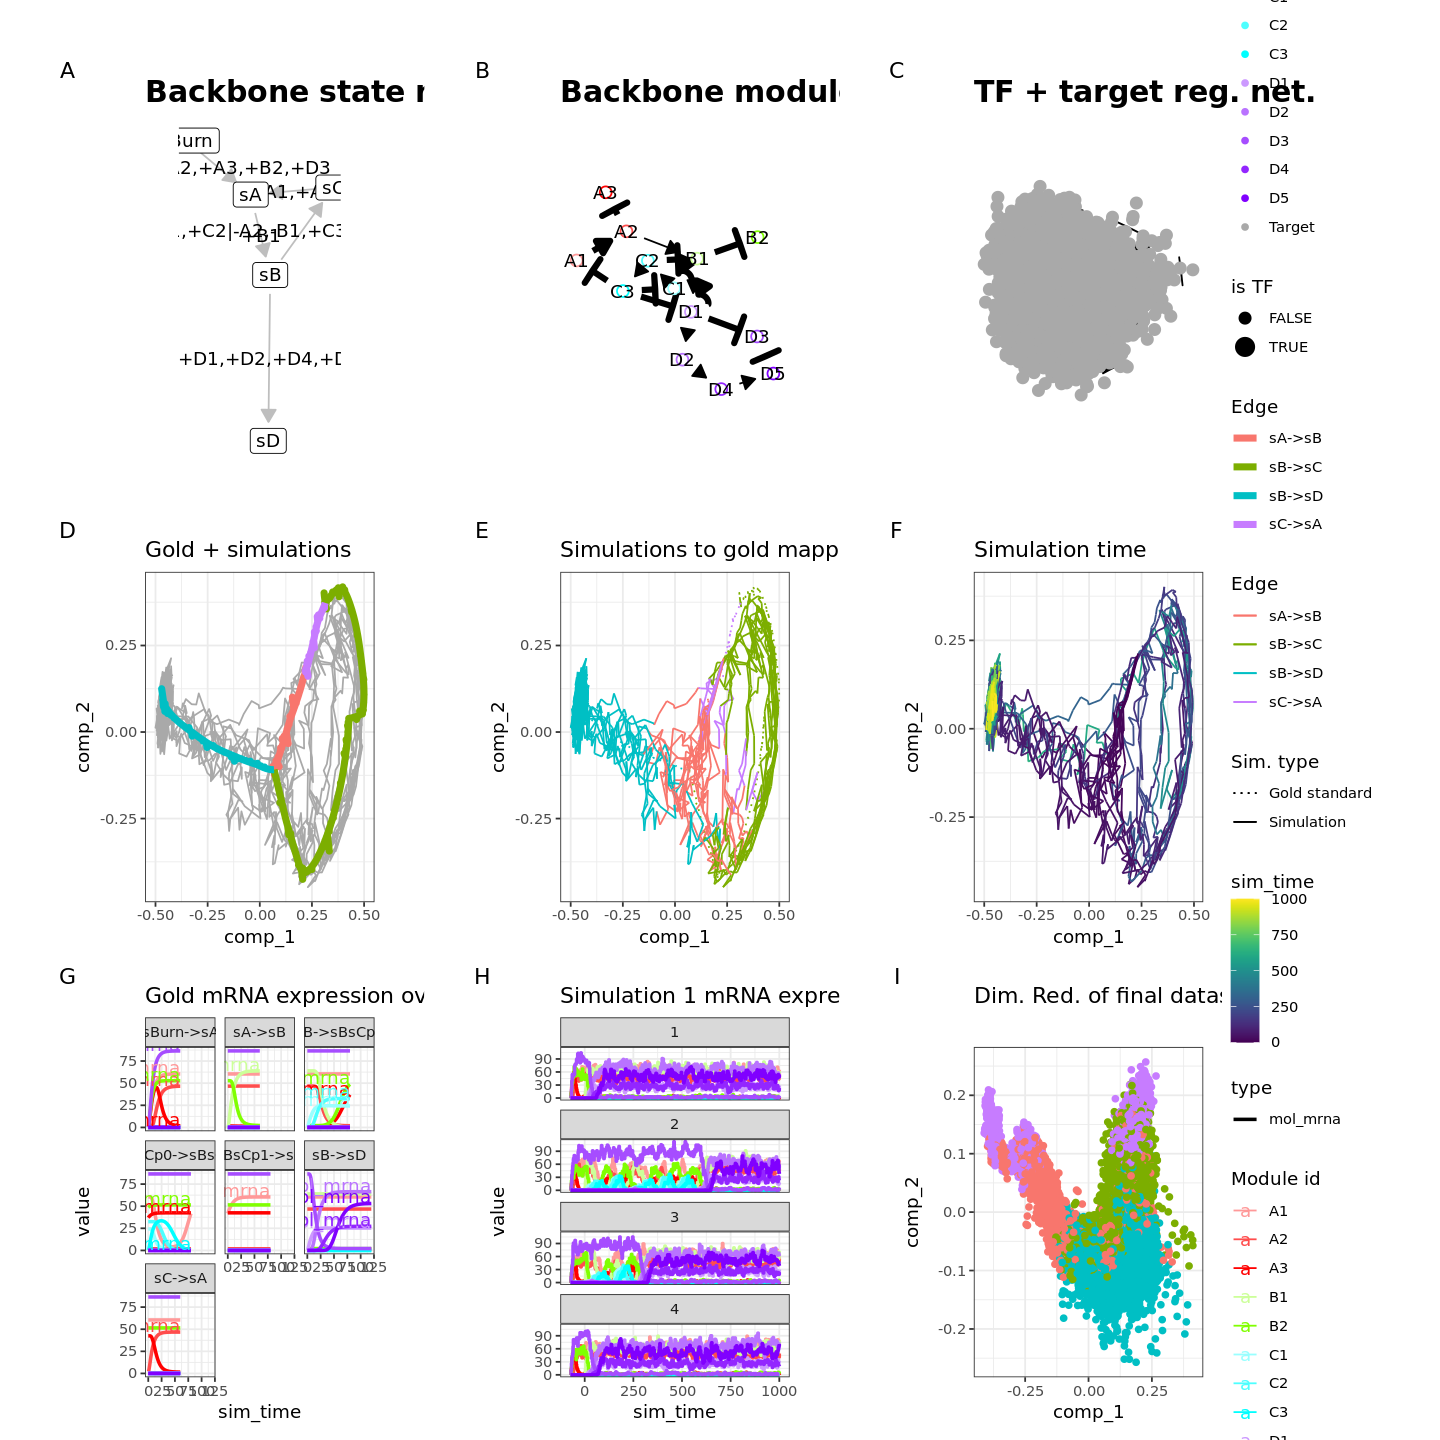

In [15]:
out <- generate_dataset(config, make_plots = TRUE)
out$plot

In [16]:
datasets <- list(
  real = t(as.matrix(realcount)),
  dyngen = t(as.matrix(out$dataset$counts))
)

ddsList <- lapply(datasets, function(ds) {
  DESeq2::DESeqDataSetFromMatrix(
    countData = round(as.matrix(ds)), 
    colData = data.frame(sample = seq_len(ncol(ds))), 
    design = ~1
  )
})

converting counts to integer mode

converting counts to integer mode



In [17]:
## Define helper objects
nDatasets <- length(ddsList)
colRow <- c(2, 1)
panelSize <- 4
thm <- theme_bw() + 
          theme(
            axis.text = element_text(size = 15),
            axis.title = element_text(size = 14),
            strip.text = element_text(size = 15)
          )

In [ ]:
obj <- countsimQC:::calculateDispersionsddsList(ddsList = ddsList, maxNForDisp = Inf)
sampleCorrDF <- countsimQC:::calculateSampleCorrs(ddsList = obj, maxNForCorr = 500)
featureCorrDF <- countsimQC:::calculateFeatureCorrs(ddsList = obj, maxNForCorr = 500)

In [ ]:
obj

In [ ]:
sampleDF <- map2_df(obj, names(obj), function(x, dataset_name) {
  tibble(
    dataset = dataset_name,
    Libsize = colSums(x$dge$counts),
    Fraczero = colMeans(x$dge$counts == 0),
    TMM = x$dge$samples$norm.factors,
    EffLibsize = Libsize * TMM
  )
})

In [ ]:
featureDF <- map2_df(obj, names(obj), function(x, dataset_name) {
  rd <- SummarizedExperiment::rowData(x$dds)
  tibble(
    dataset = dataset_name,
    Tagwise = sqrt(x$dge$tagwise.dispersion),
    Common = sqrt(x$dge$common.dispersion),
    Trend = sqrt(x$dge$trended.dispersion),
    AveLogCPM = x$dge$AveLogCPM,
    AveLogCPMDisp = x$dge$AveLogCPMDisp, 
    average_log2_cpm = apply(edgeR::cpm(x$dge, prior.count = 2, log = TRUE), 1, mean), 
    variance_log2_cpm = apply(edgeR::cpm(x$dge, prior.count = 2, log = TRUE), 1, var),
    Fraczero = rowMeans(x$dge$counts == 0),
    dispGeneEst = rd$dispGeneEst,
    dispFit = rd$dispFit,
    dispFinal = rd$dispersion,
    baseMeanDisp = rd$baseMeanDisp,
    baseMean = rd$baseMean
  )
})

In [ ]:
datasetDF <- map2_df(obj, names(obj), function(x, dataset_name) {
  tibble(
    dataset = dataset_name,
    prior_df = paste0("prior.df = ", round(x$dge$prior.df, 2)),
    nVars = nrow(x$dge$counts),
    nSamples = ncol(x$dge$counts),
    AveLogCPMDisp = 0.8 * max(featureDF$AveLogCPMDisp),
    Tagwise = 0.9 * max(featureDF$Tagwise)
  )
})

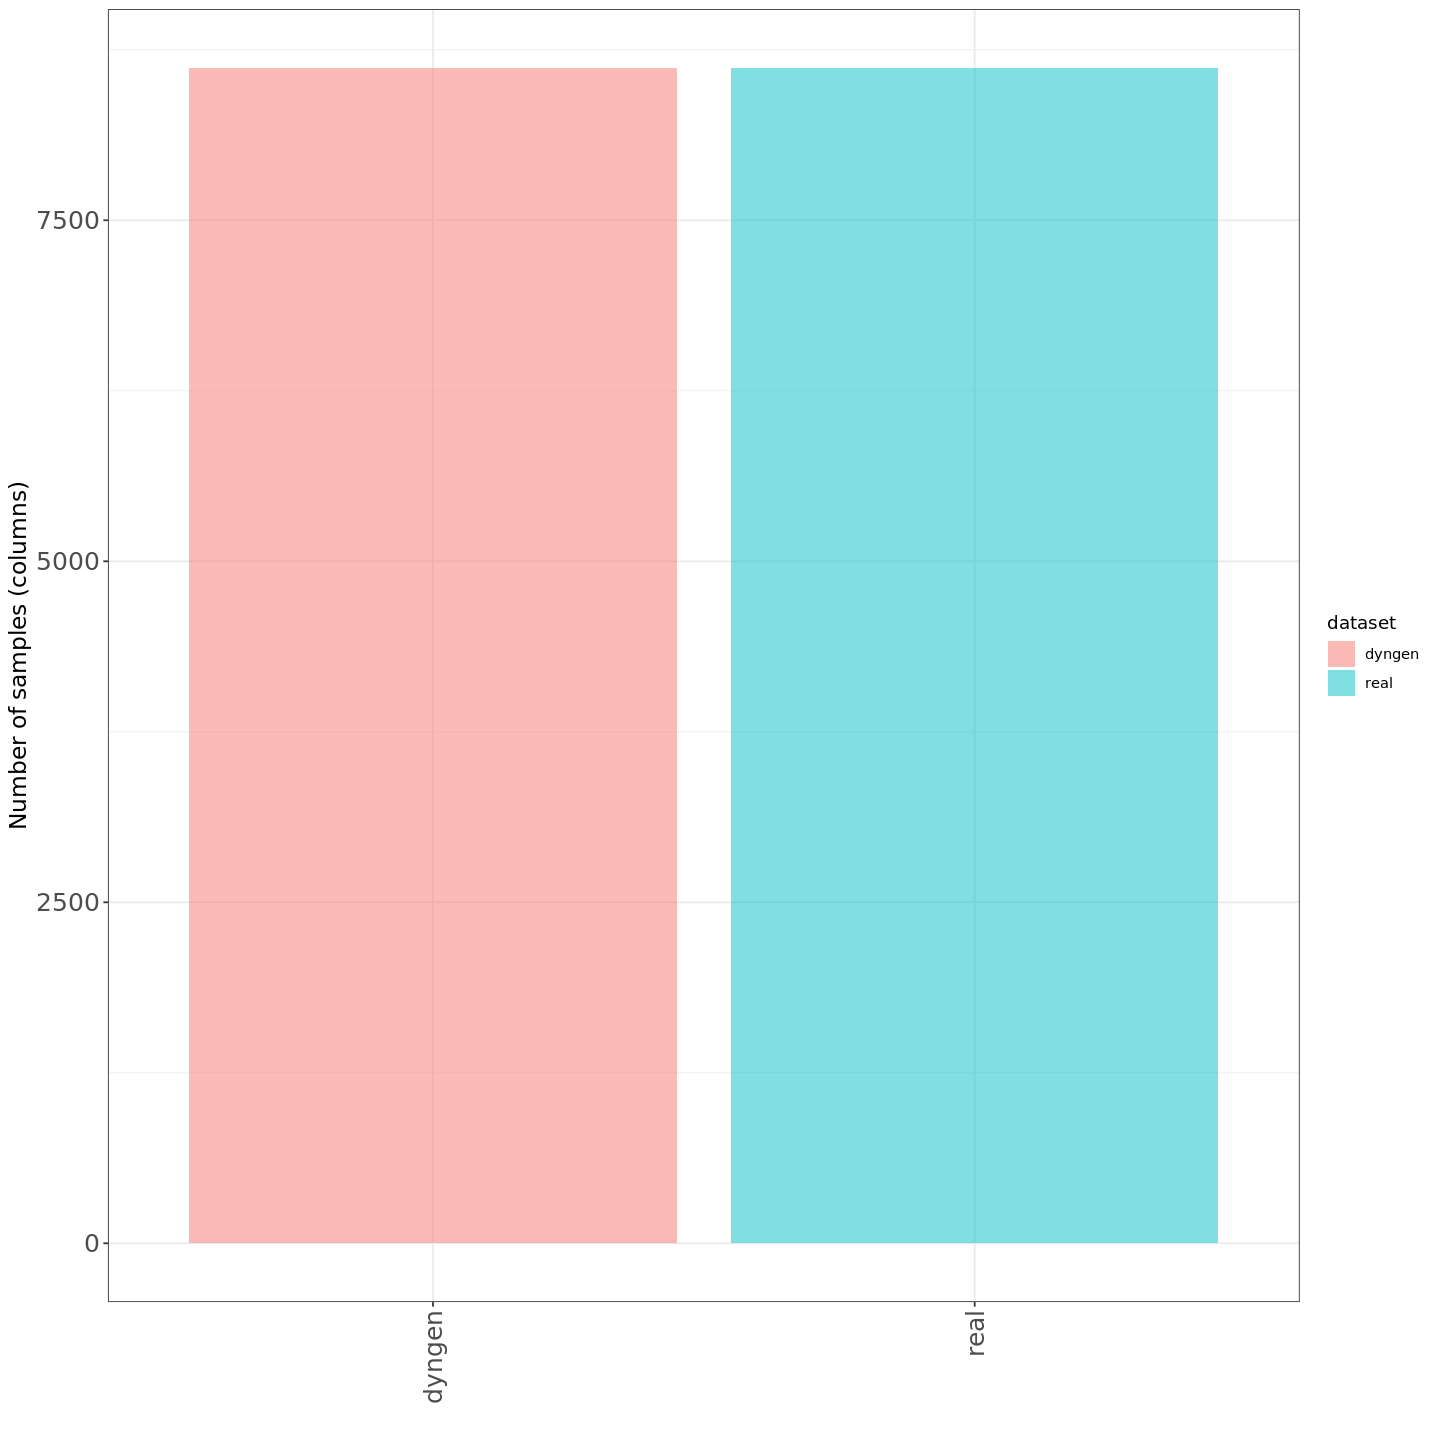

In [38]:
ggplot(datasetDF, aes(x = dataset, y = nSamples, fill = dataset)) + 
  geom_bar(stat = "identity", alpha = 0.5) + 
  xlab("") + ylab("Number of samples (columns)") + 
  thm + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

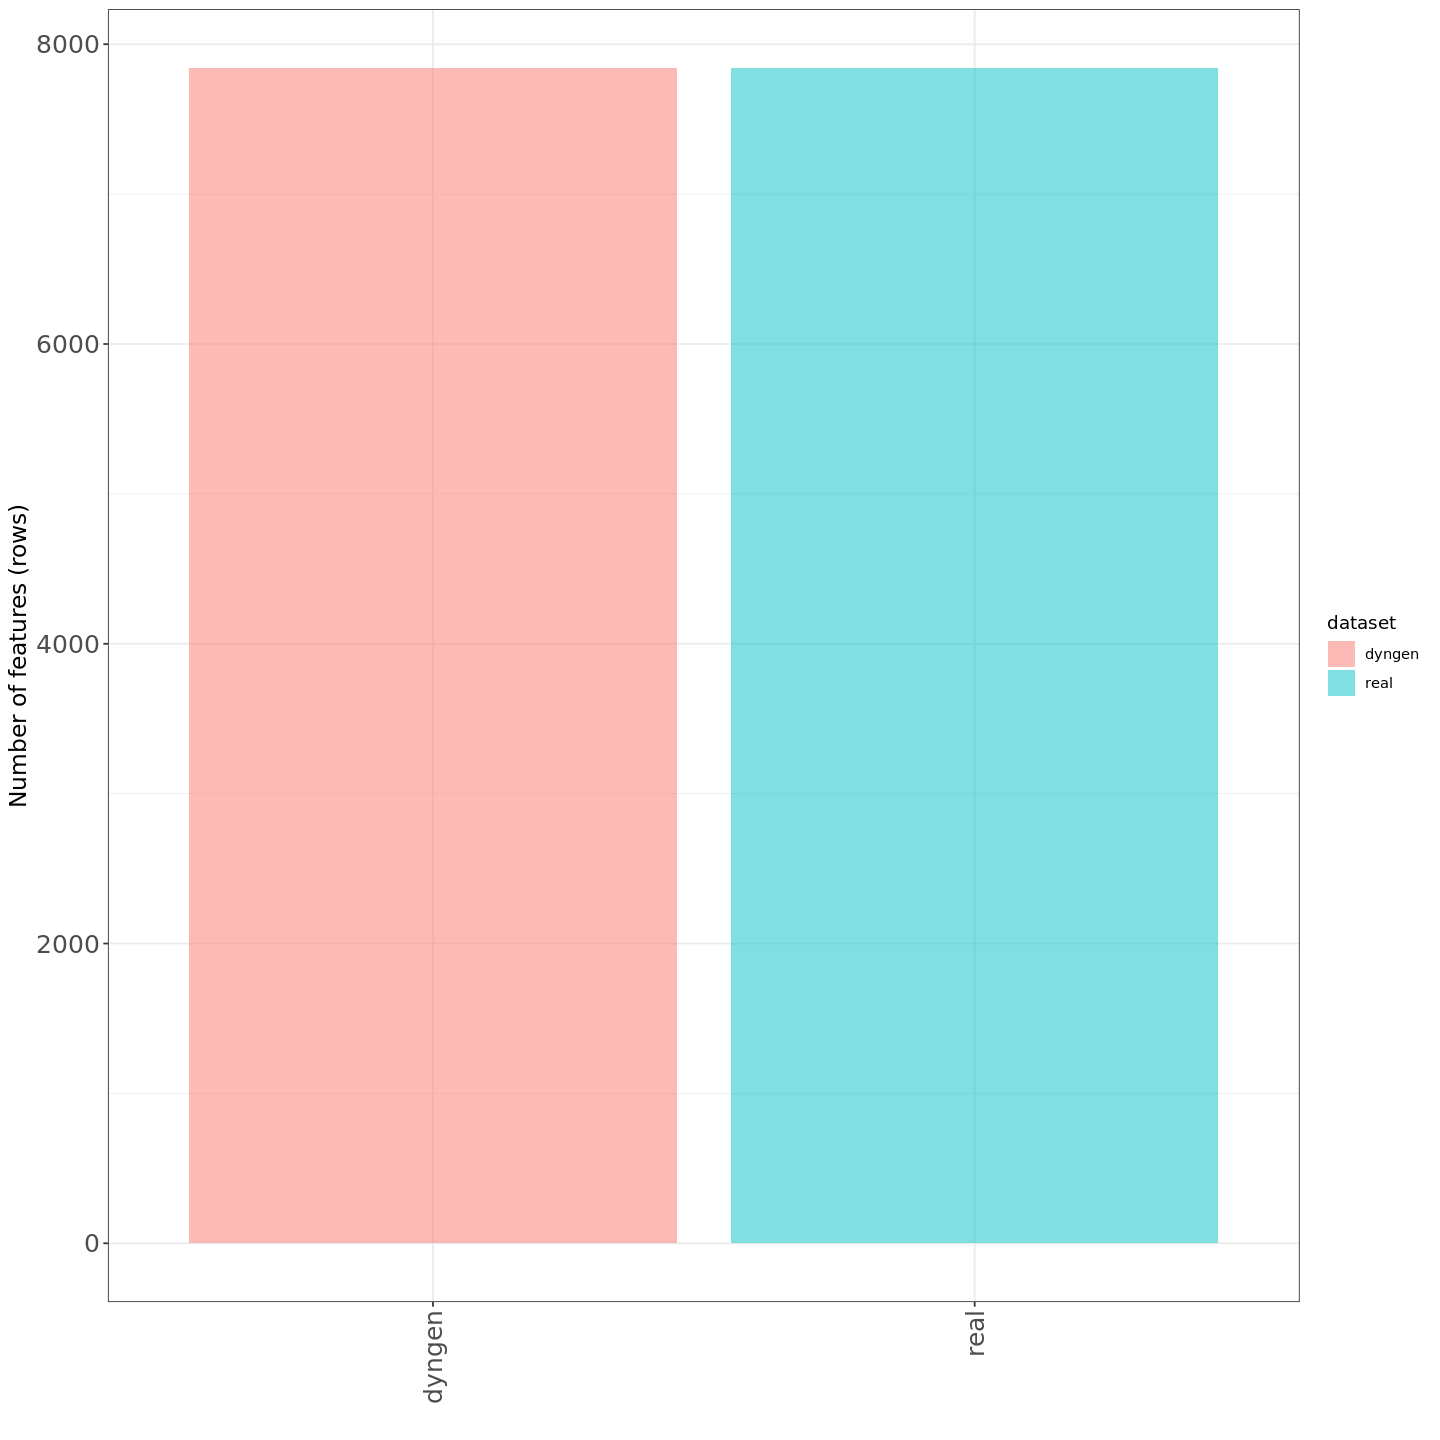

In [39]:
ggplot(datasetDF, aes(x = dataset, y = nVars, fill = dataset)) + 
  geom_bar(stat = "identity", alpha = 0.5) + 
  xlab("") + ylab("Number of features (rows)") + 
  thm + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

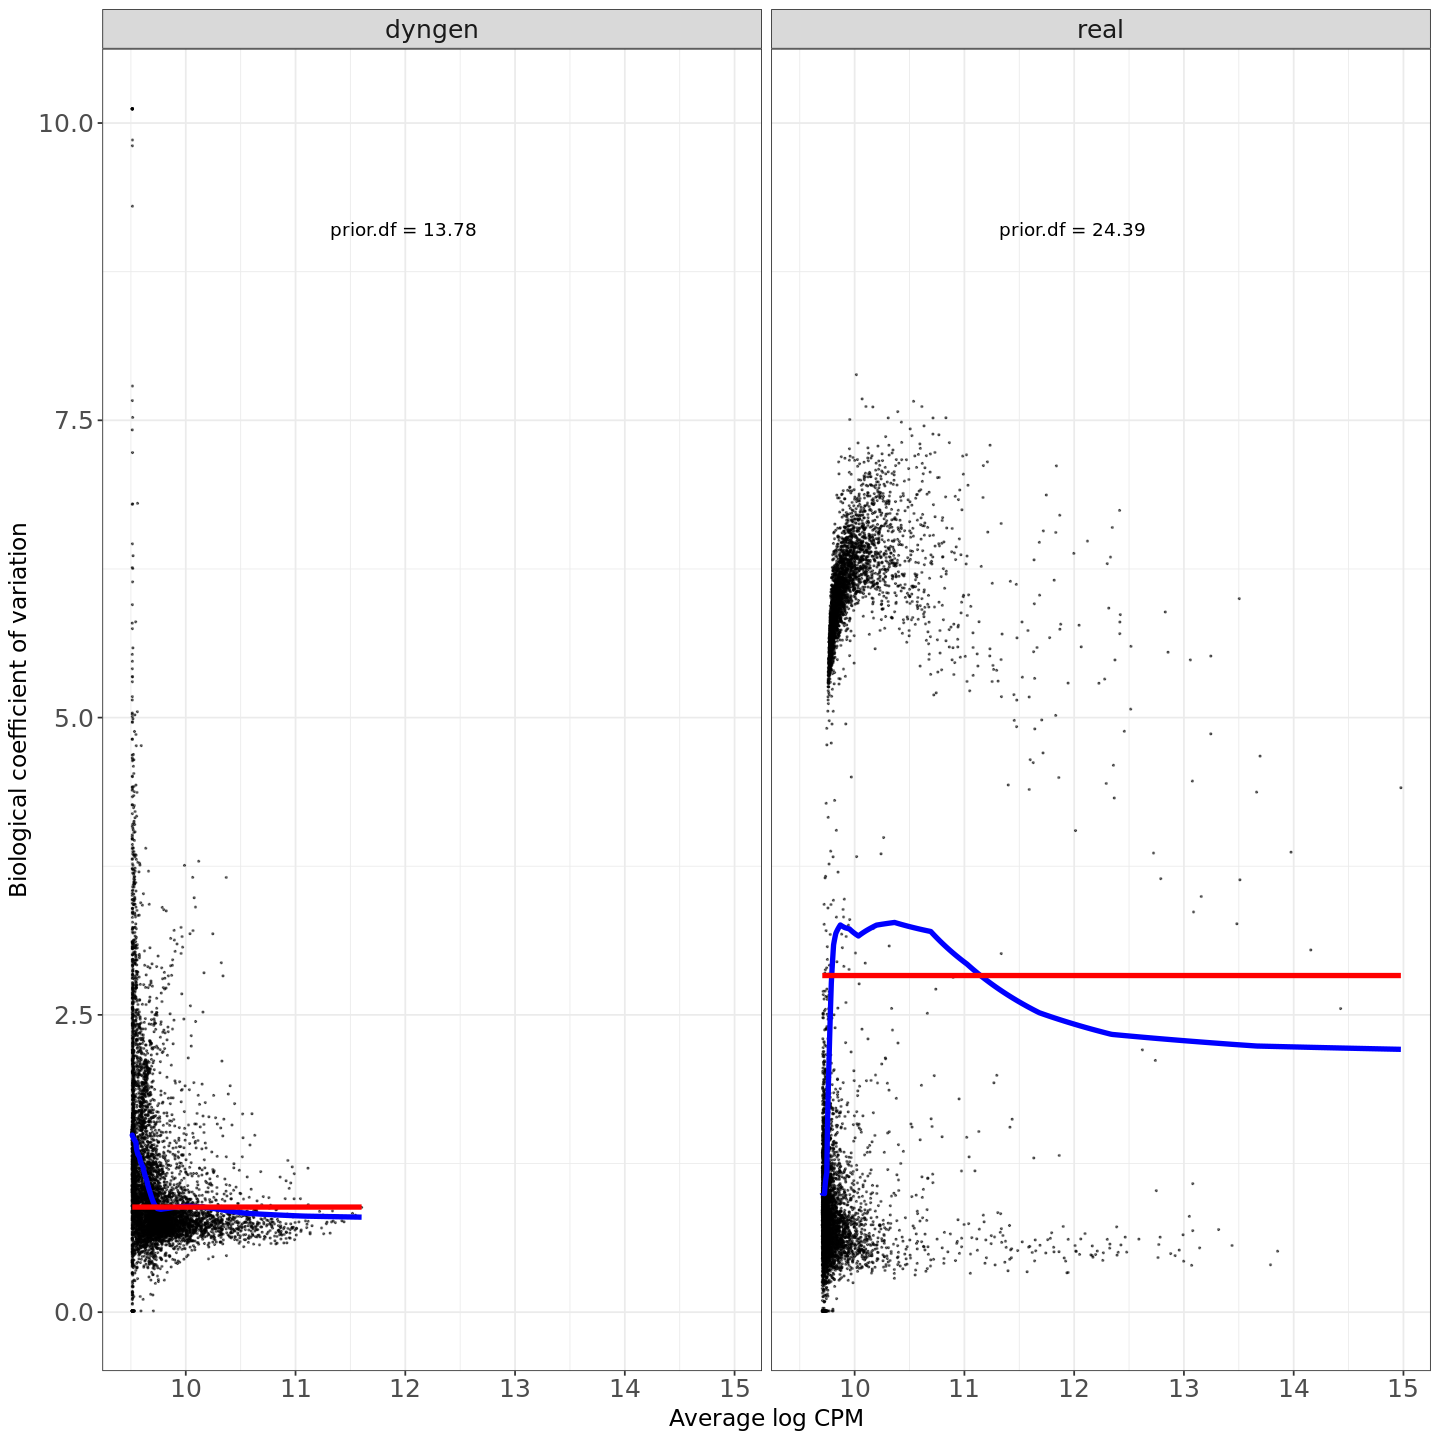

In [40]:
ggplot(featureDF %>% dplyr::arrange(AveLogCPMDisp), 
       aes(x = AveLogCPMDisp, y = Tagwise)) + 
  geom_point(size = 0.25, alpha = 0.5) + 
  facet_wrap(~dataset, nrow = colRow[2]) + 
  geom_line(aes(y = Trend), color = "blue", size = 1.5) + 
  geom_line(aes(y = Common), color = "red", size = 1.5) +
  geom_text(data = datasetDF, aes(label = prior_df)) + 
  xlab("Average log CPM") + ylab("Biological coefficient of variation") + 
  thm

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 138 rows containing missing values (geom_point).”
Warning message:
“Removed 138 rows containing missing values (geom_point).”
Warning message:
“Removed 138 row(s) containing missing values (geom_path).”


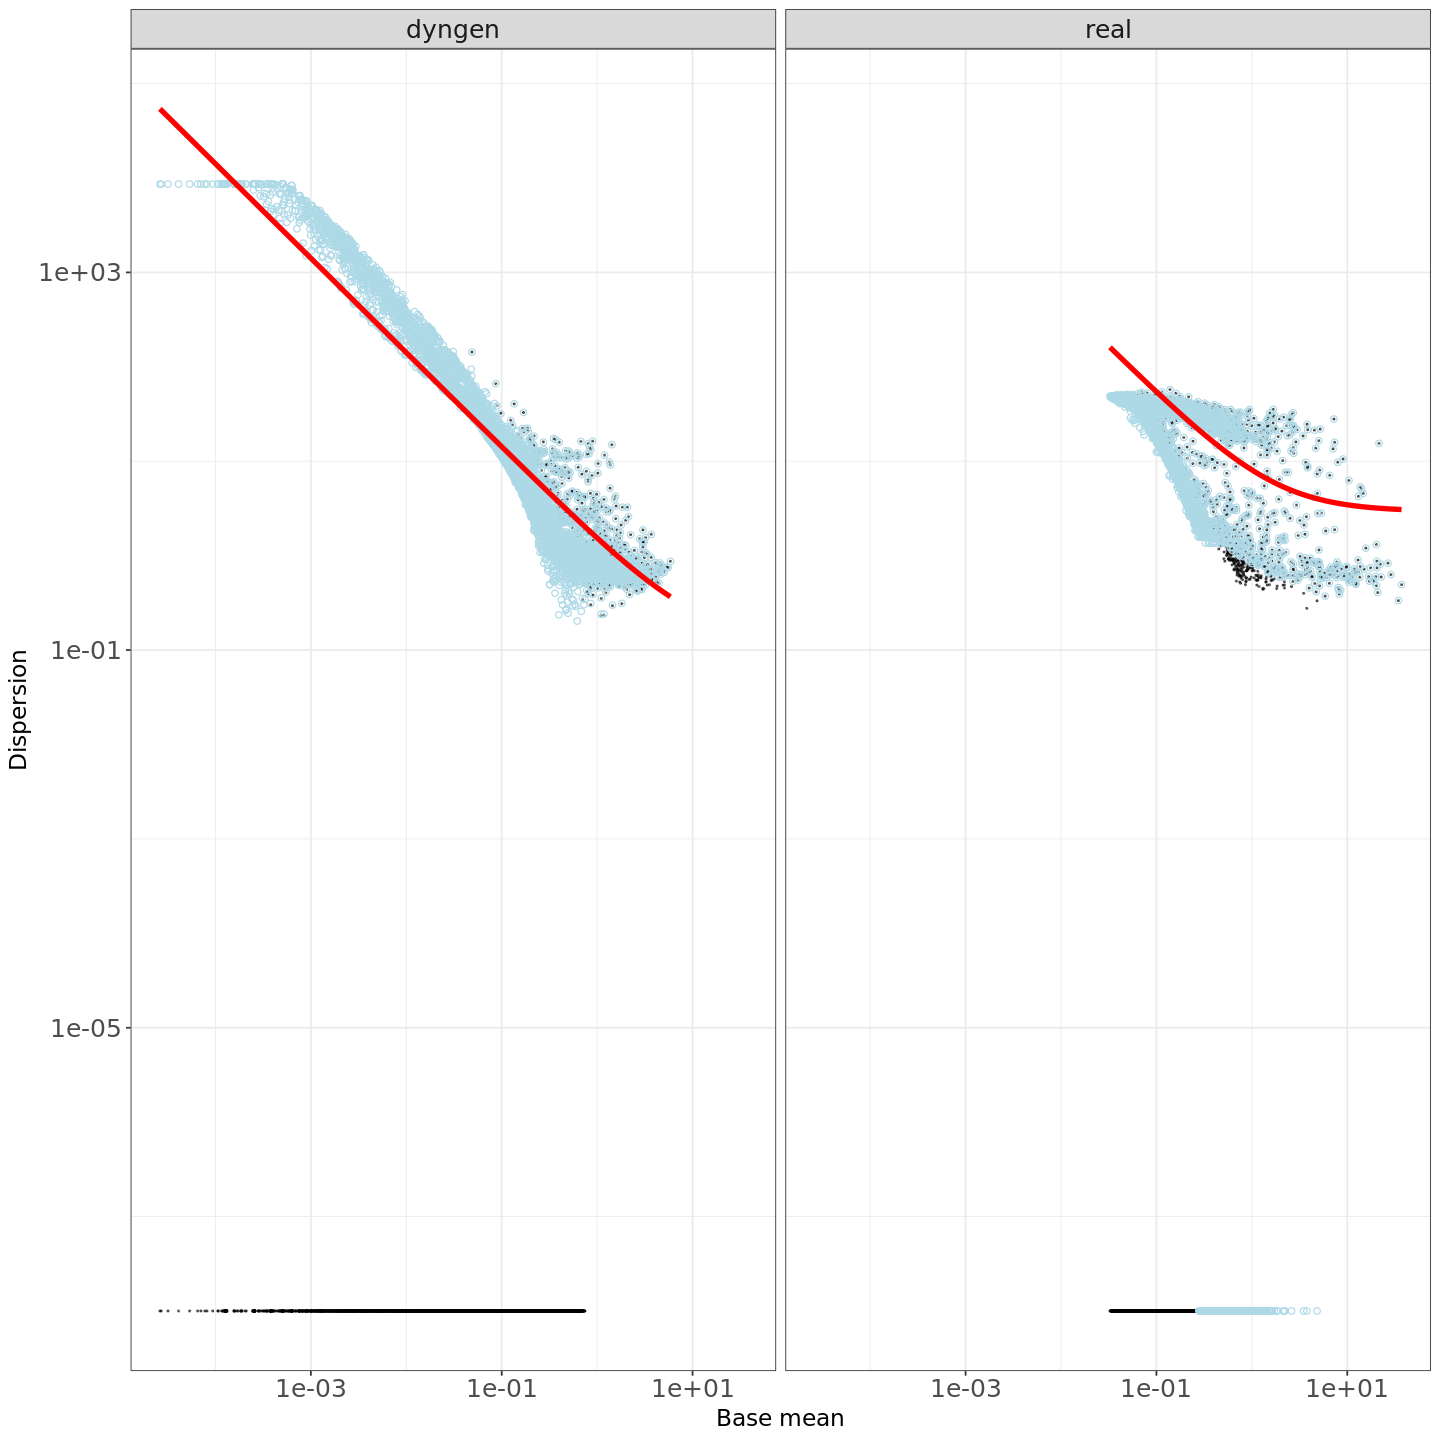

In [41]:
ggplot(featureDF %>% dplyr::arrange(baseMeanDisp), 
       aes(x = baseMeanDisp, y = dispGeneEst)) + 
  geom_point(size = 0.25, alpha = 0.5) + 
  facet_wrap(~dataset, nrow = colRow[2]) + scale_x_log10() + scale_y_log10() +  
  geom_point(aes(y = dispFinal), color = "lightblue", shape = 21) + 
  geom_line(aes(y = dispFit), color = "red", size = 1.5) + 
  xlab("Base mean") + ylab("Dispersion") + 
  thm

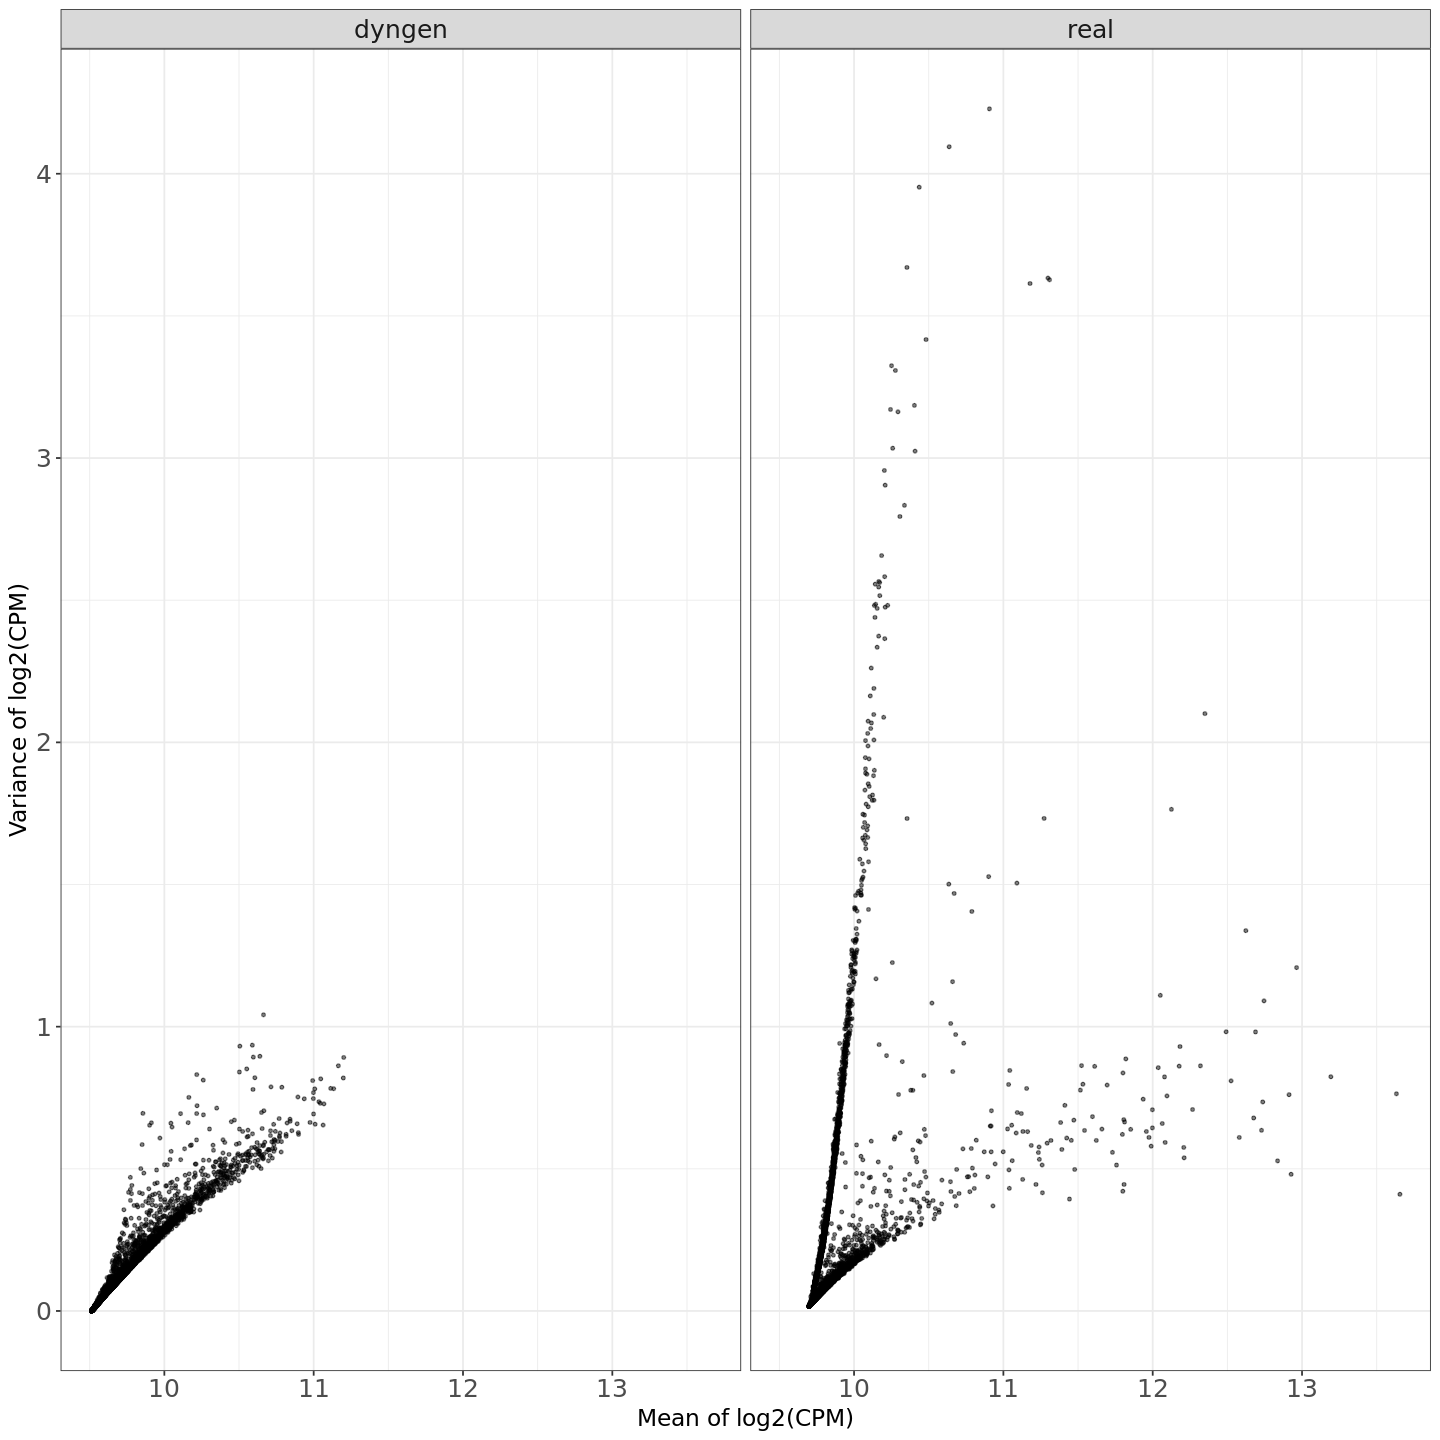

In [42]:
ggplot(featureDF, aes(x = average_log2_cpm, y = variance_log2_cpm)) + 
  geom_point(size = 0.75, alpha = 0.5) + 
  facet_wrap(~dataset, nrow = colRow[2]) + 
  xlab("Mean of log2(CPM)") + ylab("Variance of log2(CPM)") + 
  thm

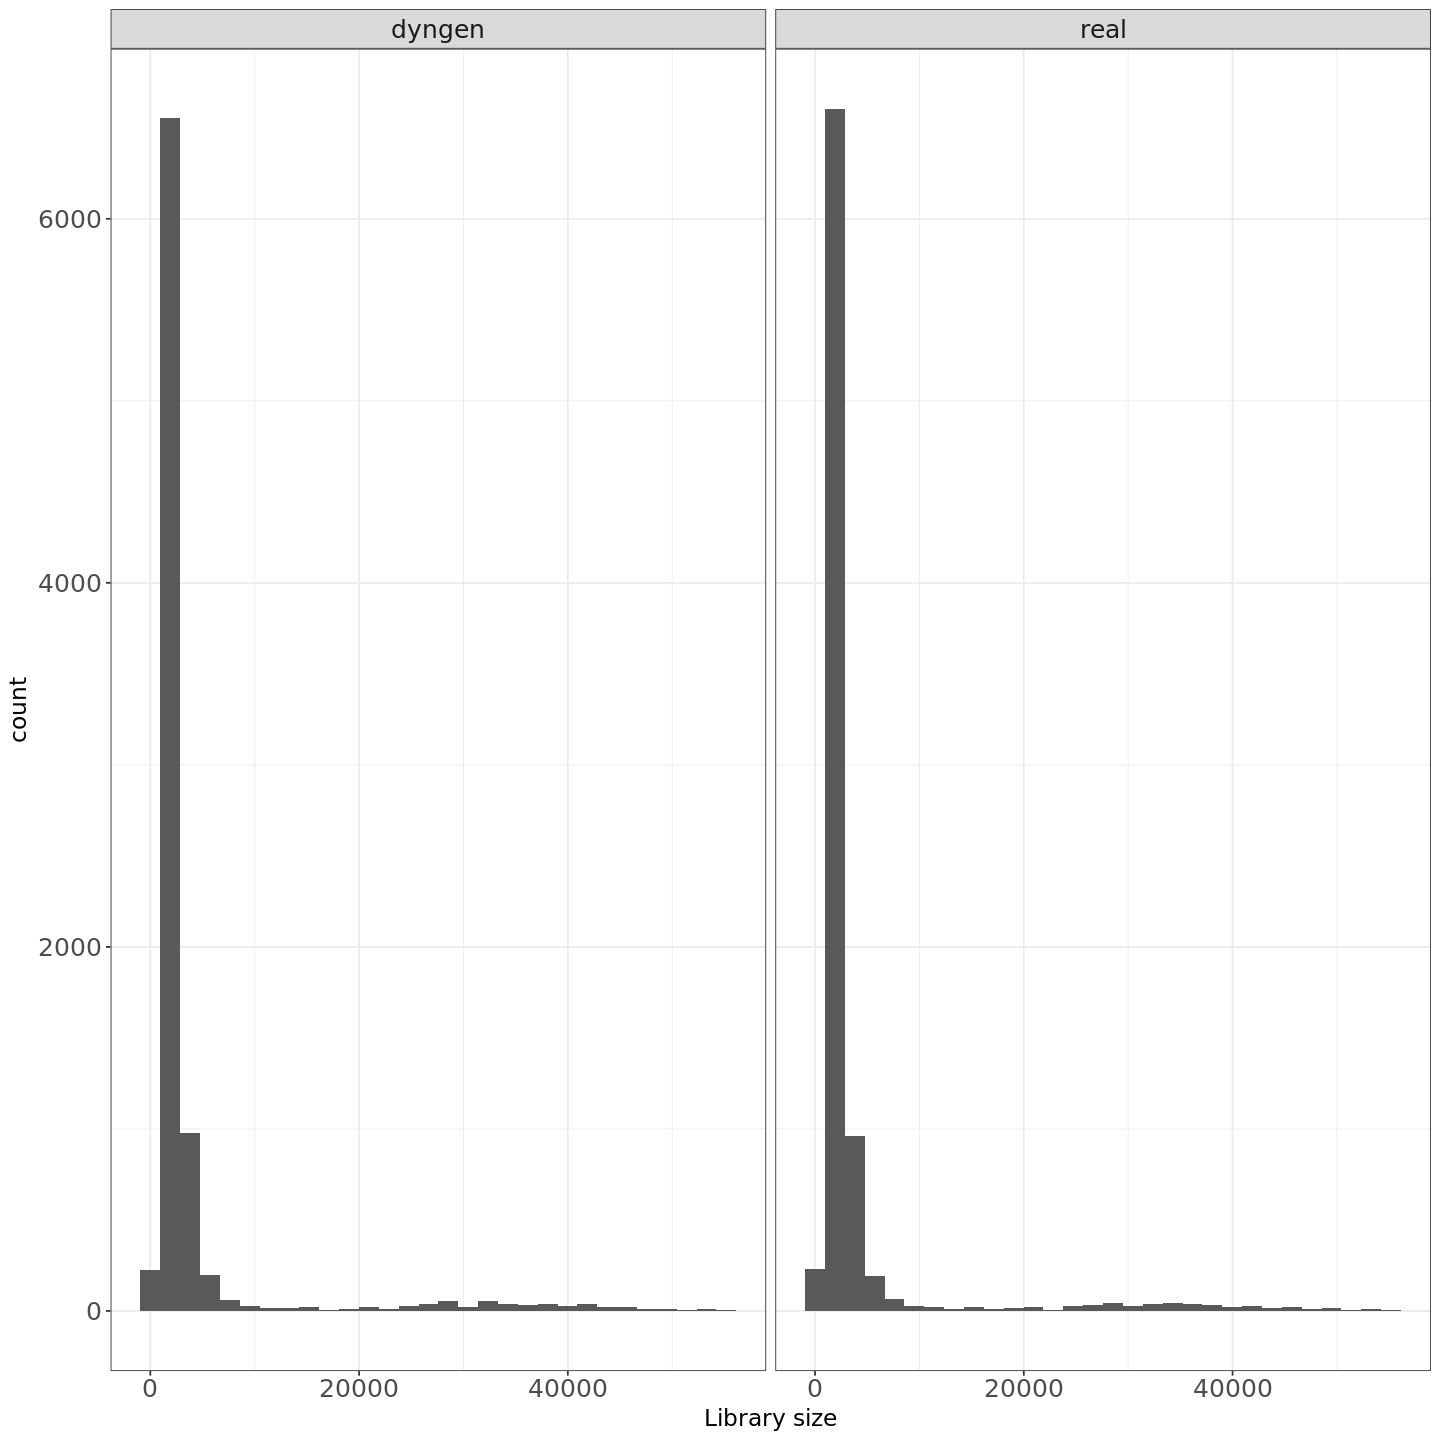

In [43]:
ggplot(sampleDF, aes(x = Libsize)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Library size") + thm

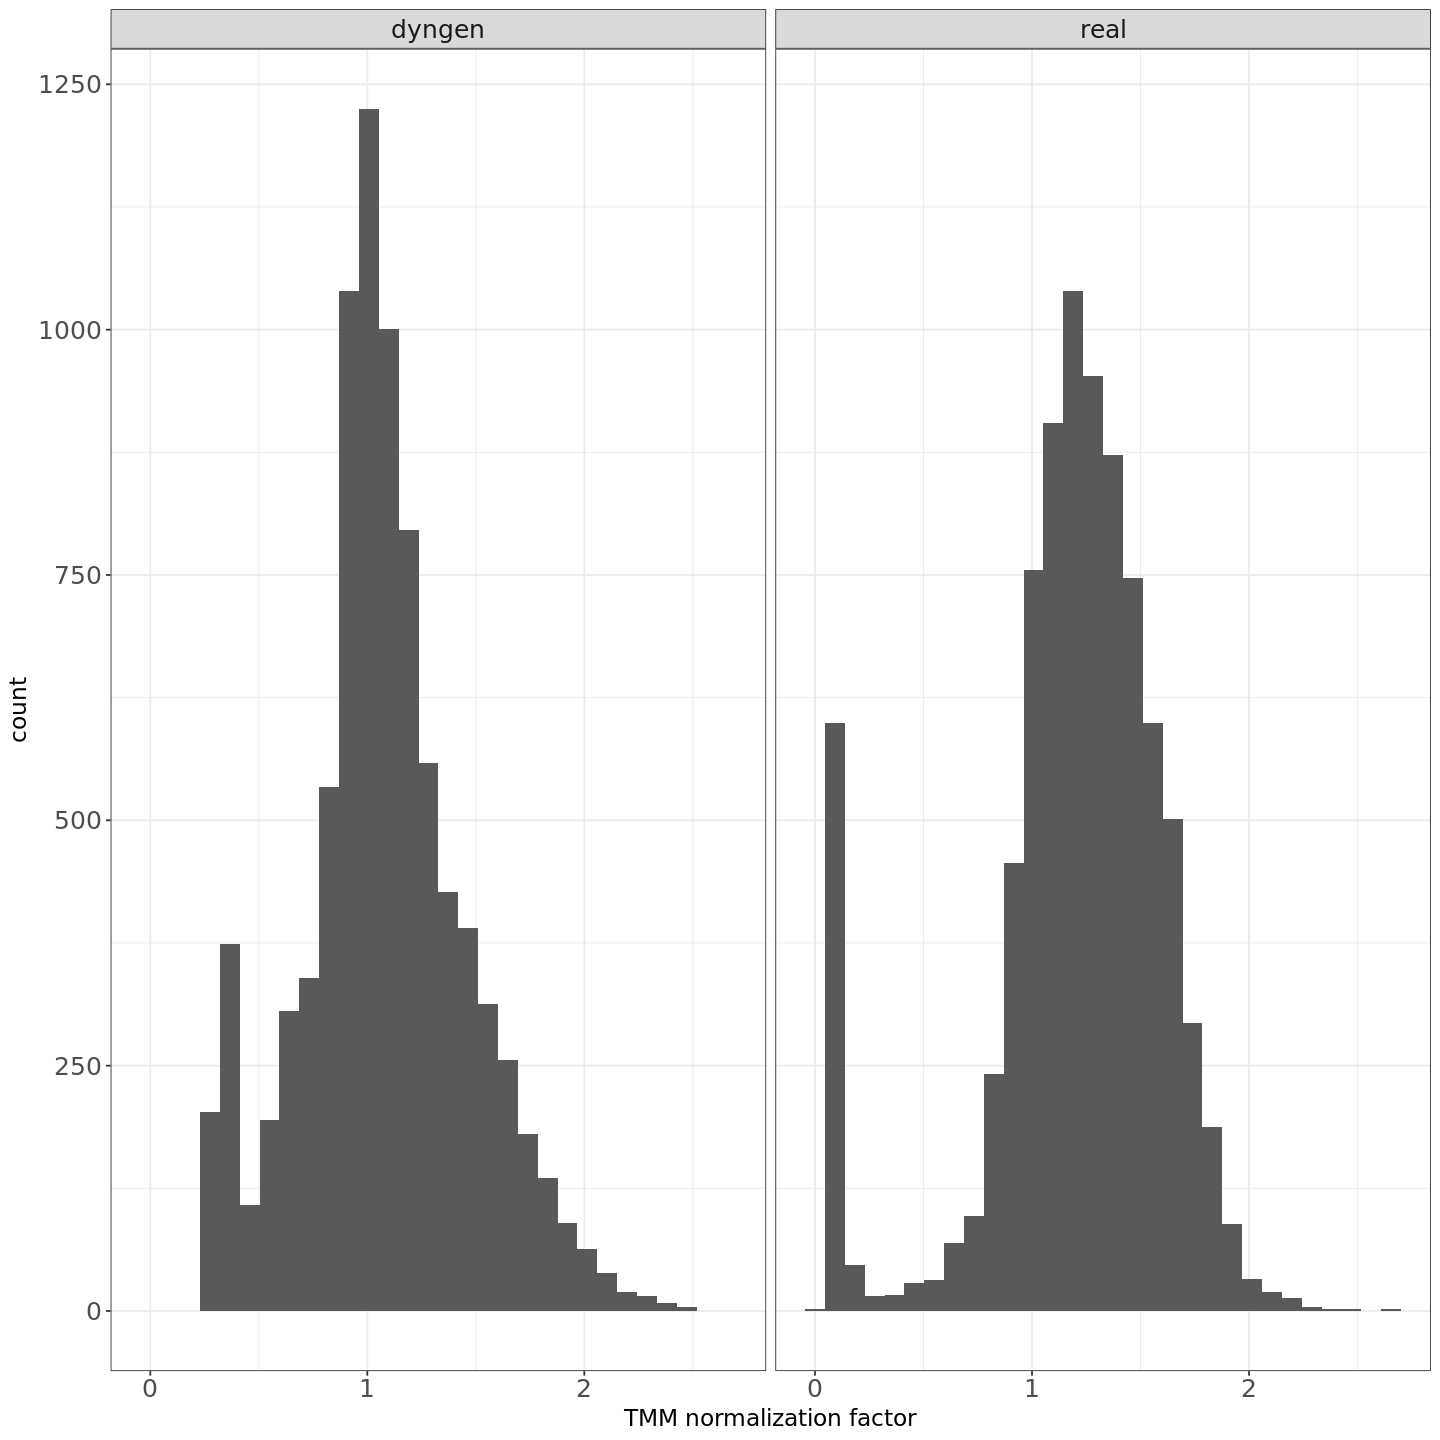

In [44]:
ggplot(sampleDF, aes(x = TMM)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("TMM normalization factor") + thm

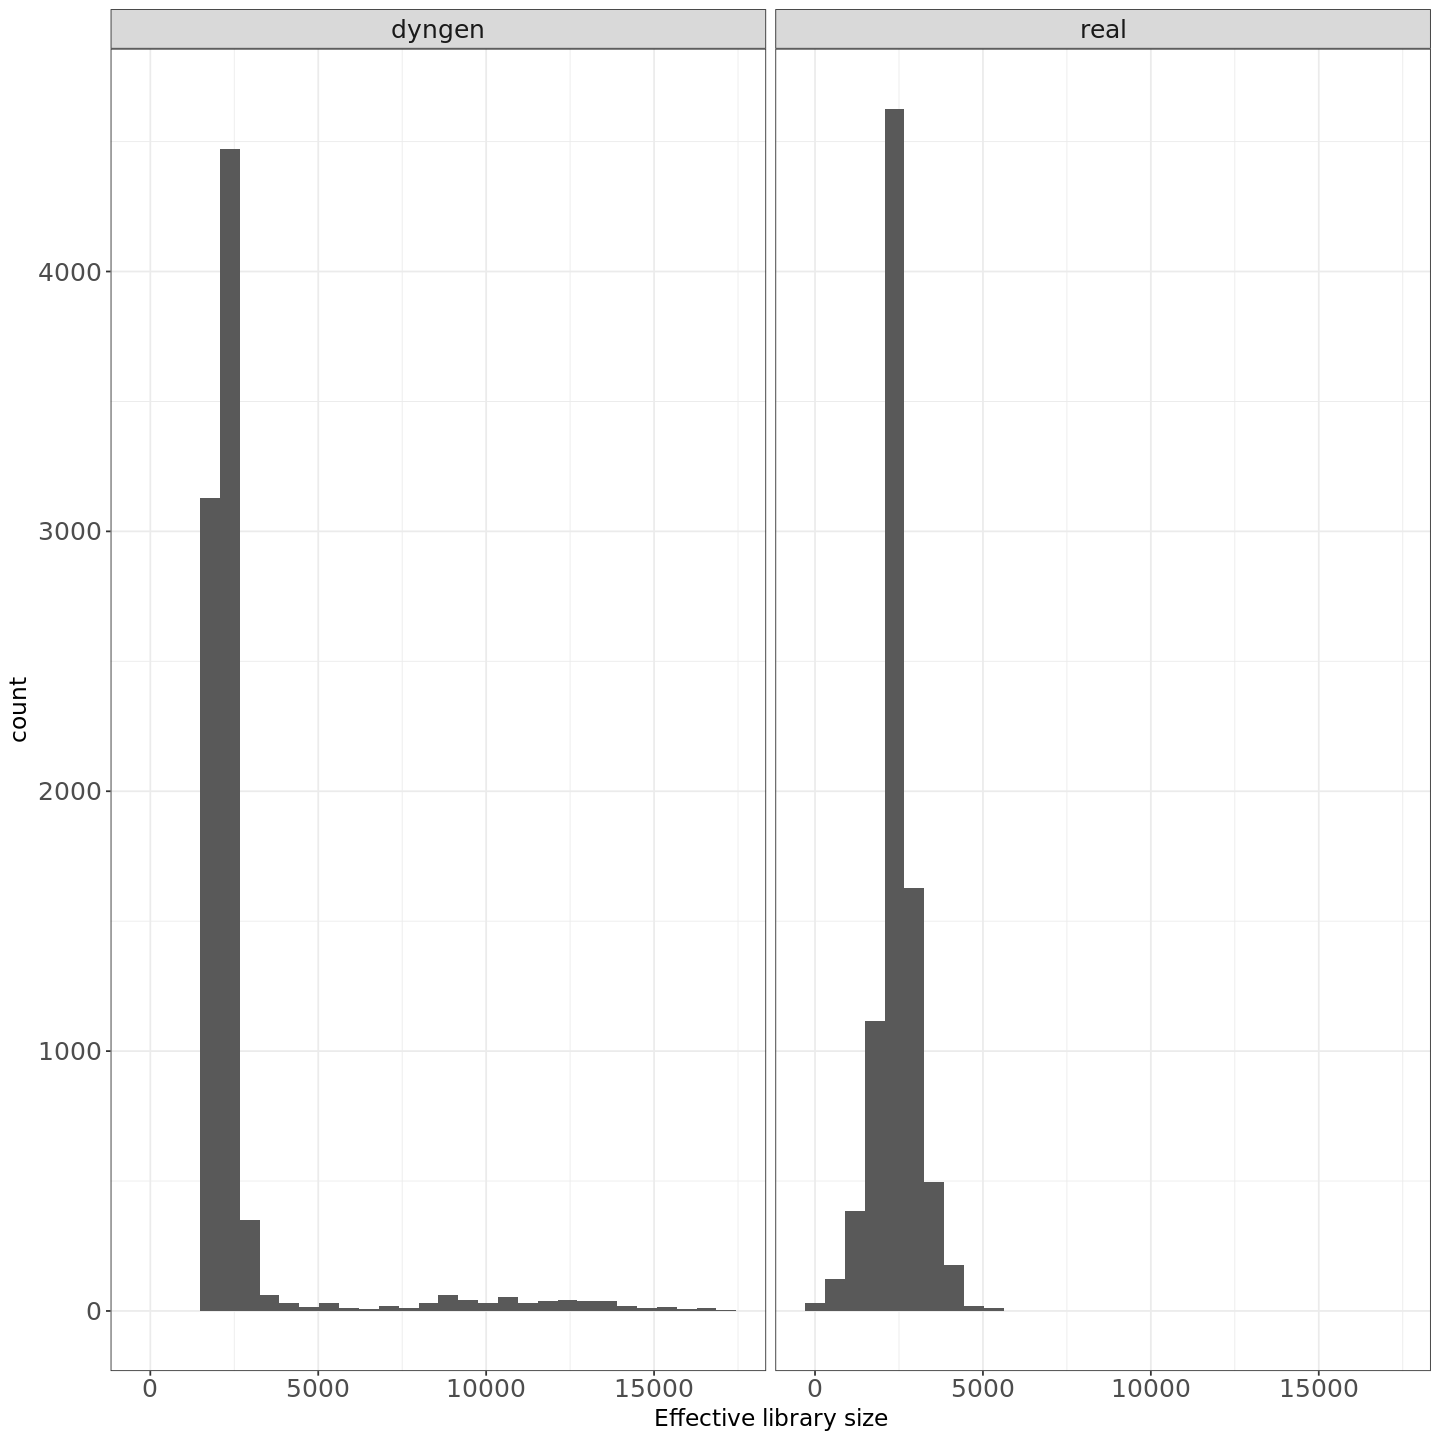

In [45]:
ggplot(sampleDF, aes(x = EffLibsize)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Effective library size") + thm

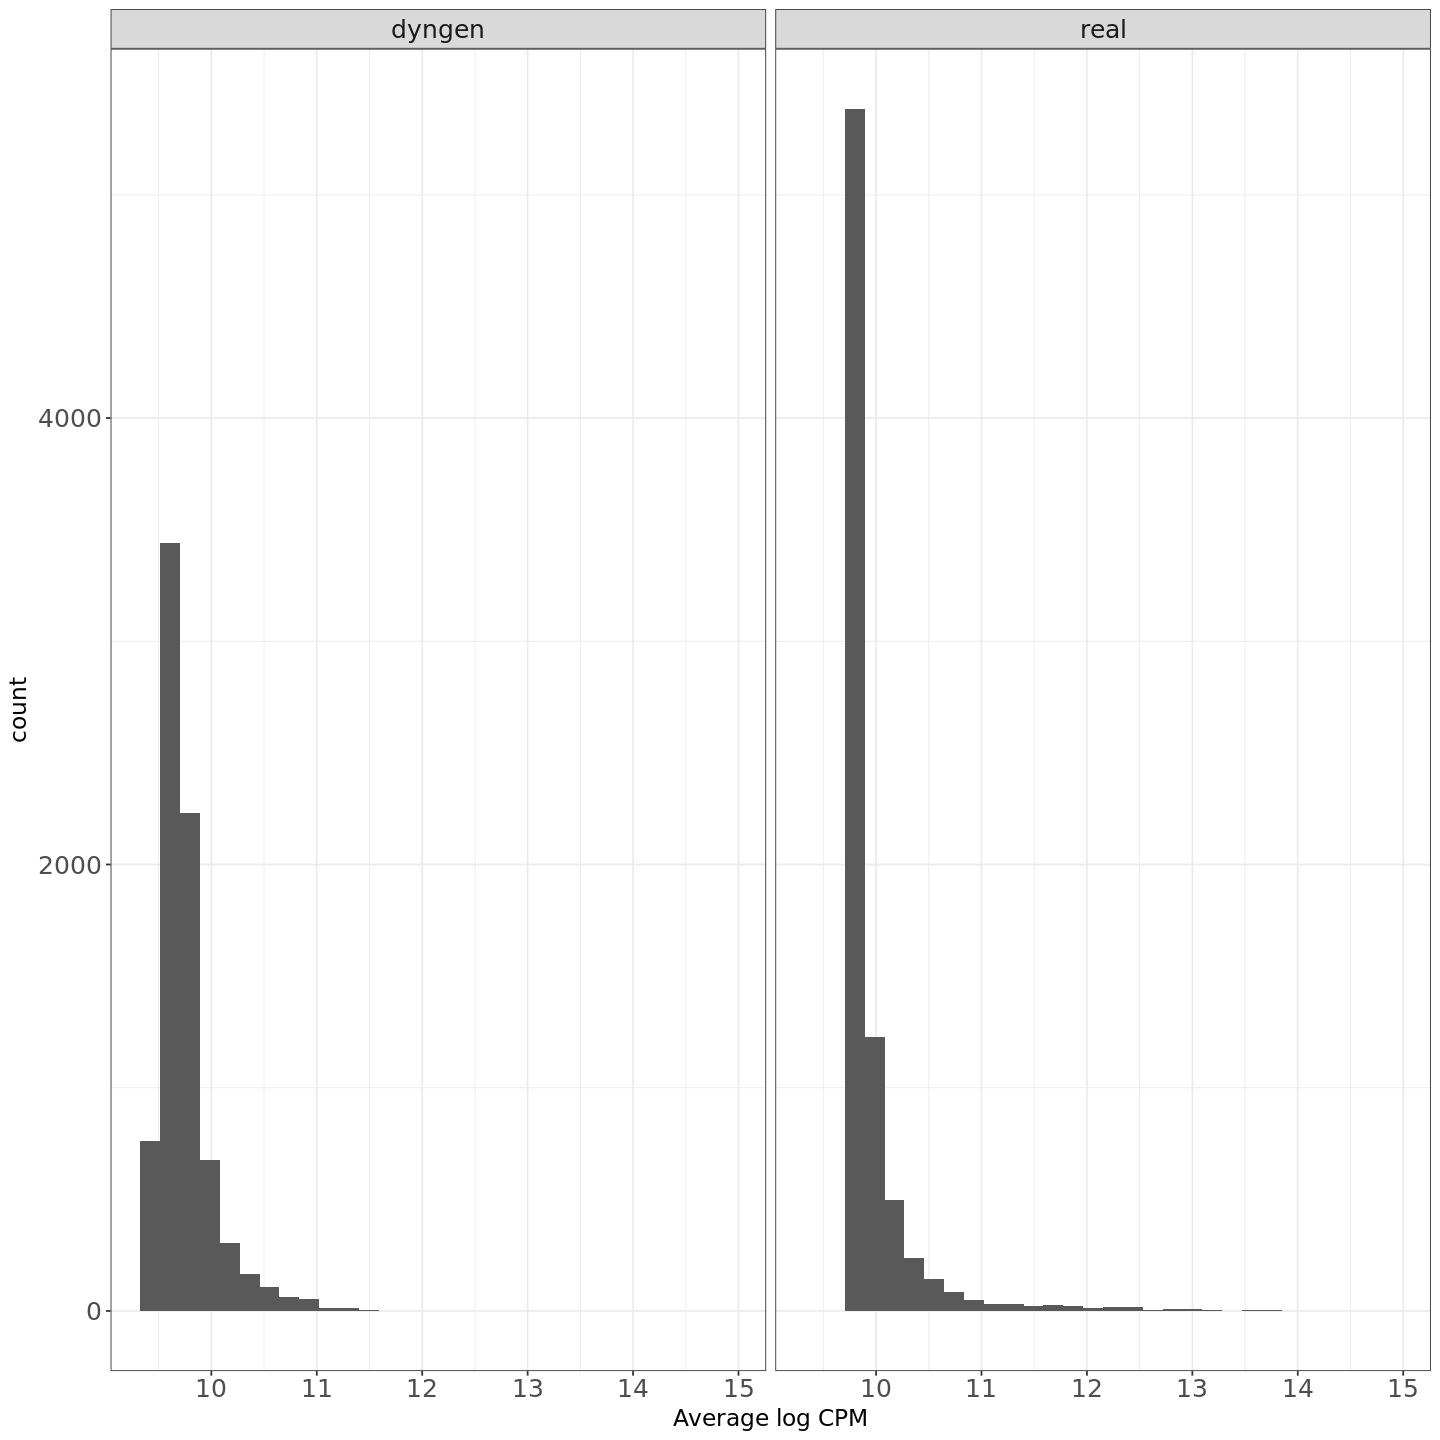

In [46]:
ggplot(featureDF, aes(x = AveLogCPM)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Average log CPM") + thm

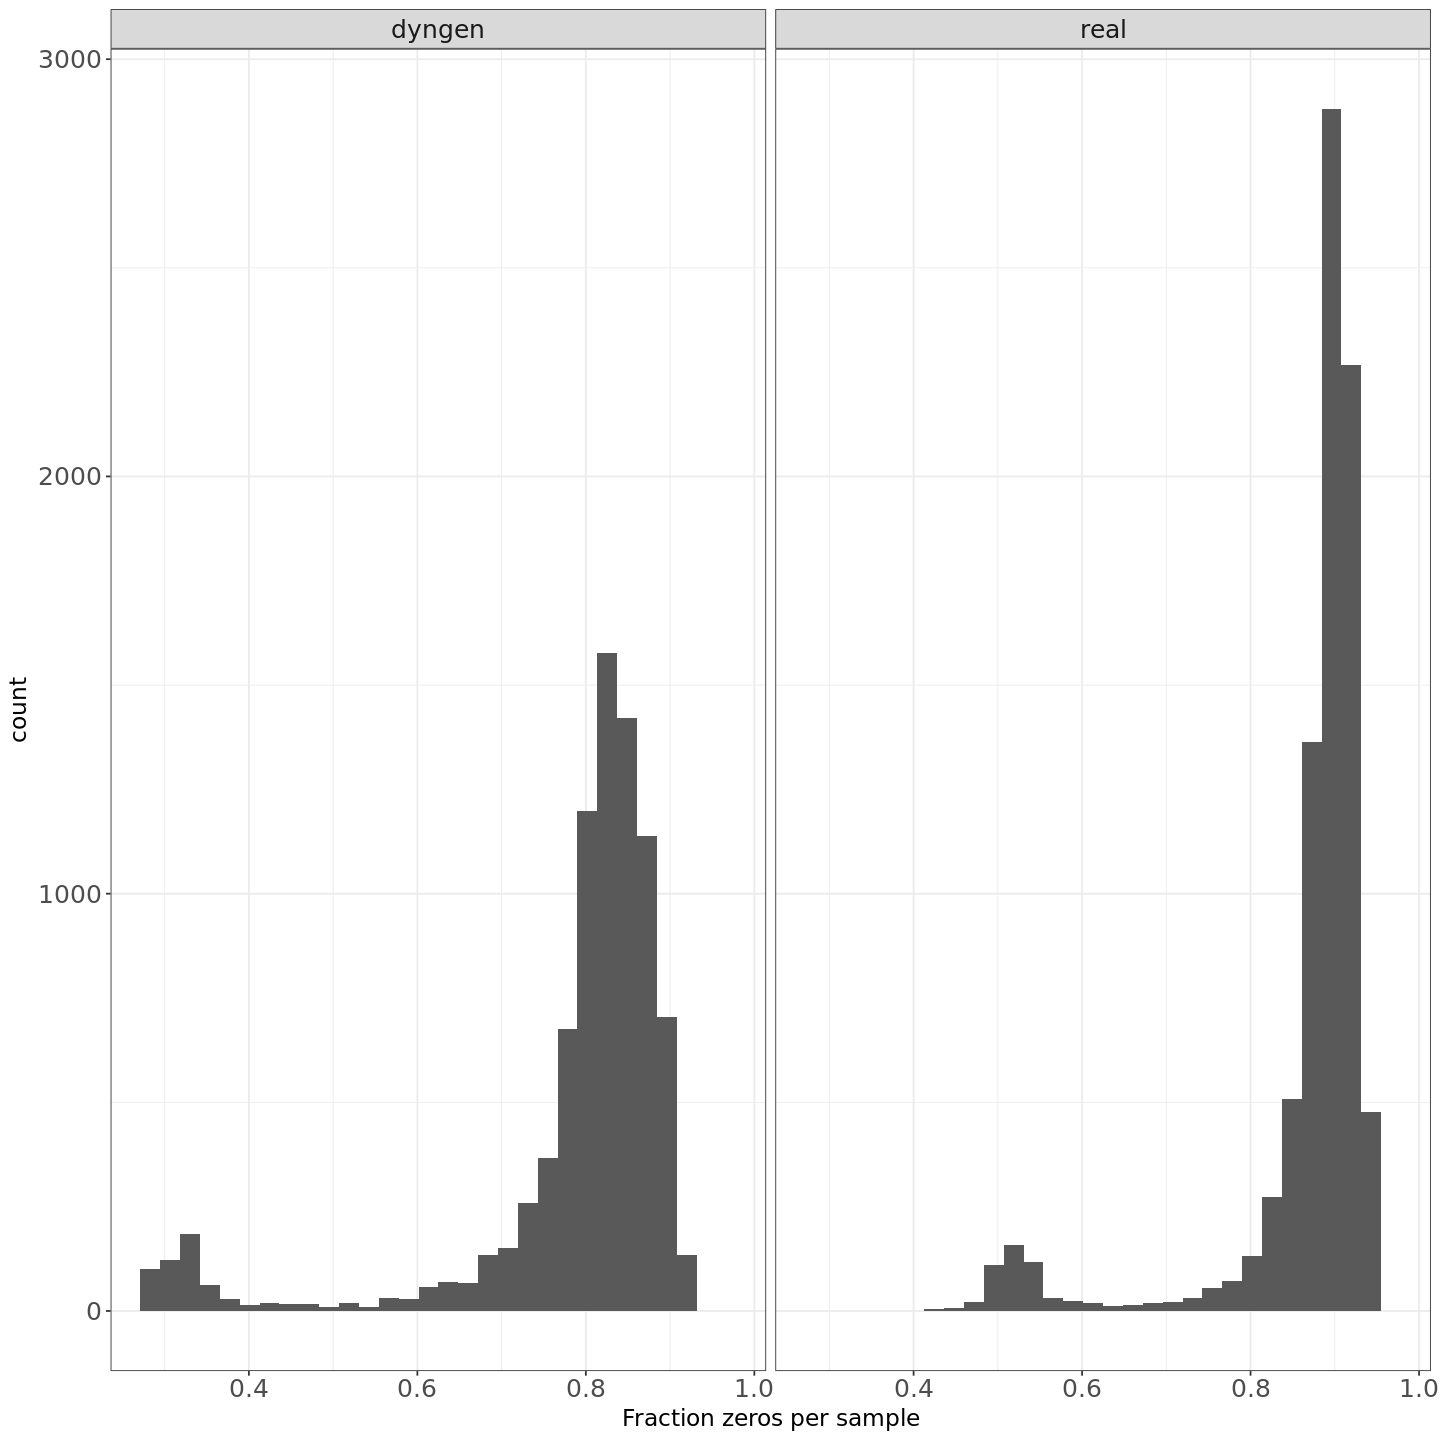

In [47]:
ggplot(sampleDF, aes(x = Fraczero)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Fraction zeros per sample") + thm

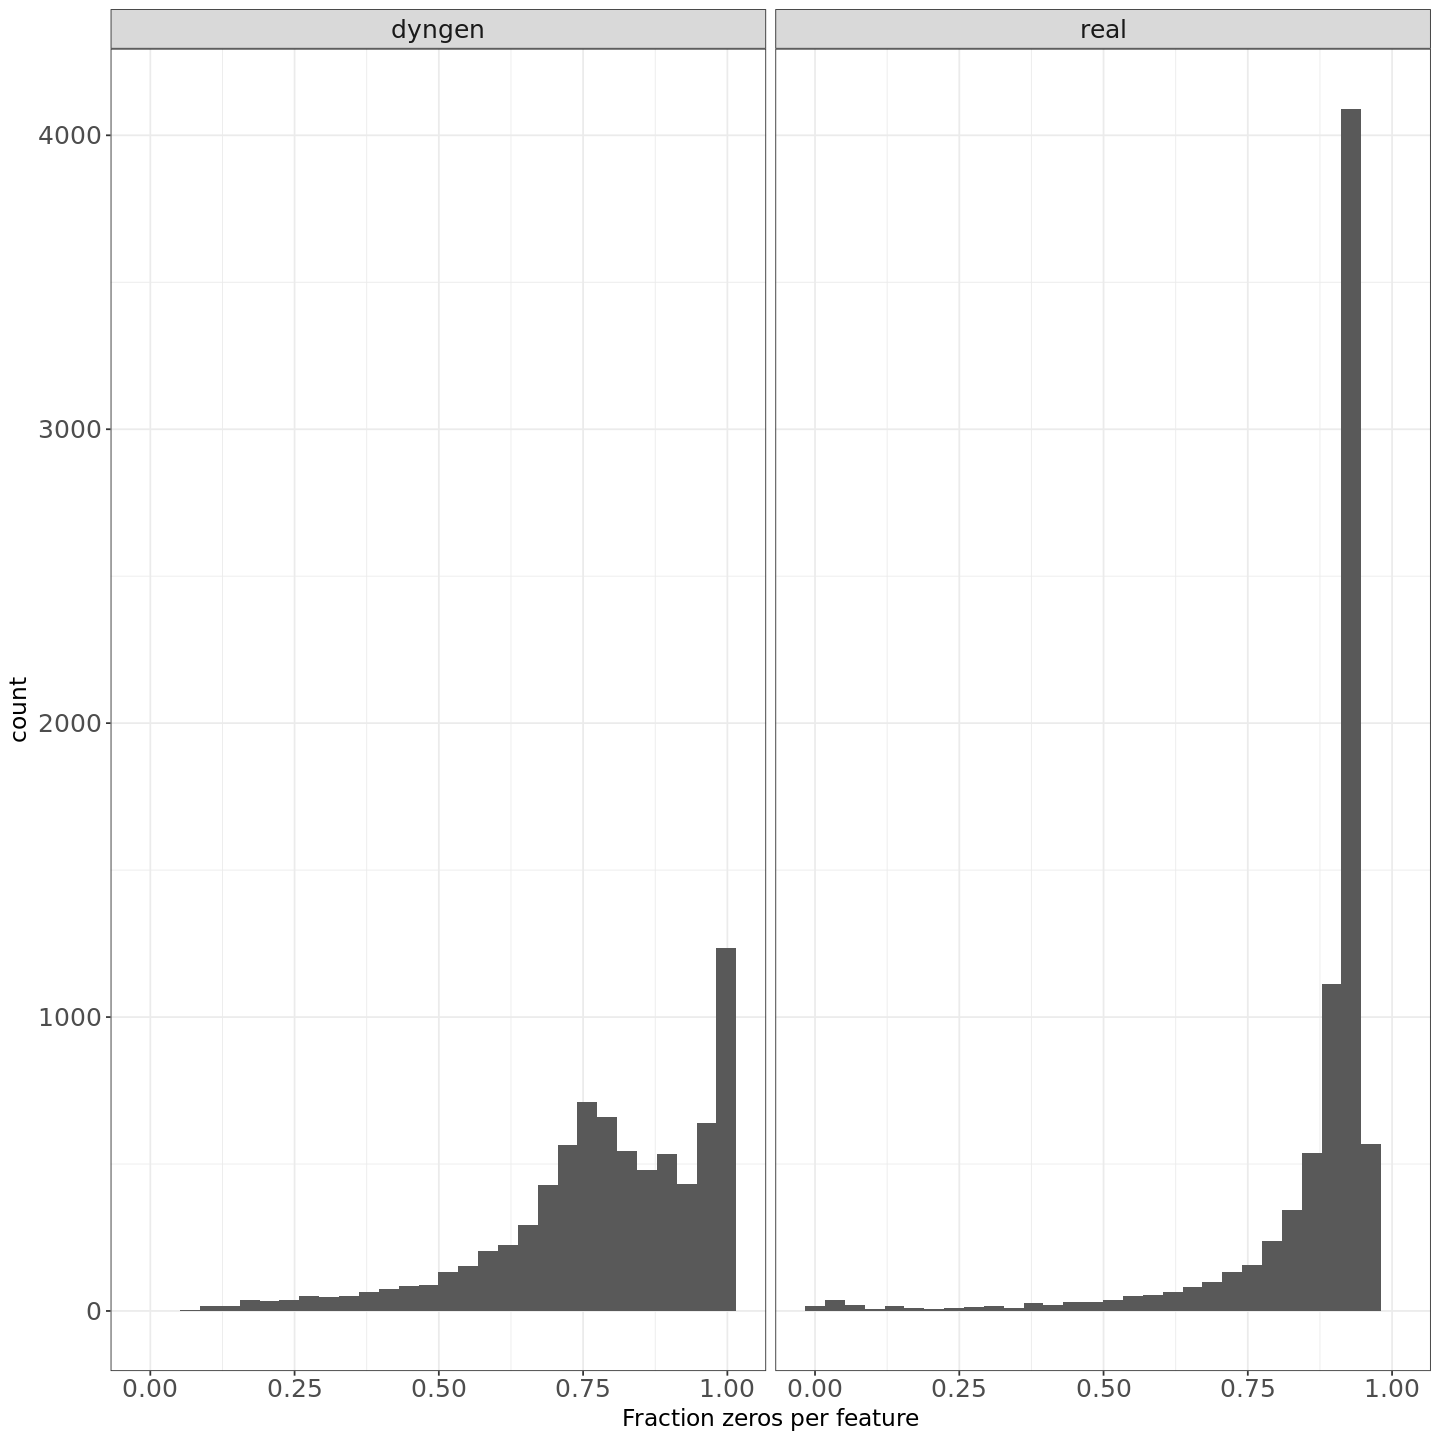

In [48]:
ggplot(featureDF, aes(x = Fraczero)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Fraction zeros per feature") + thm

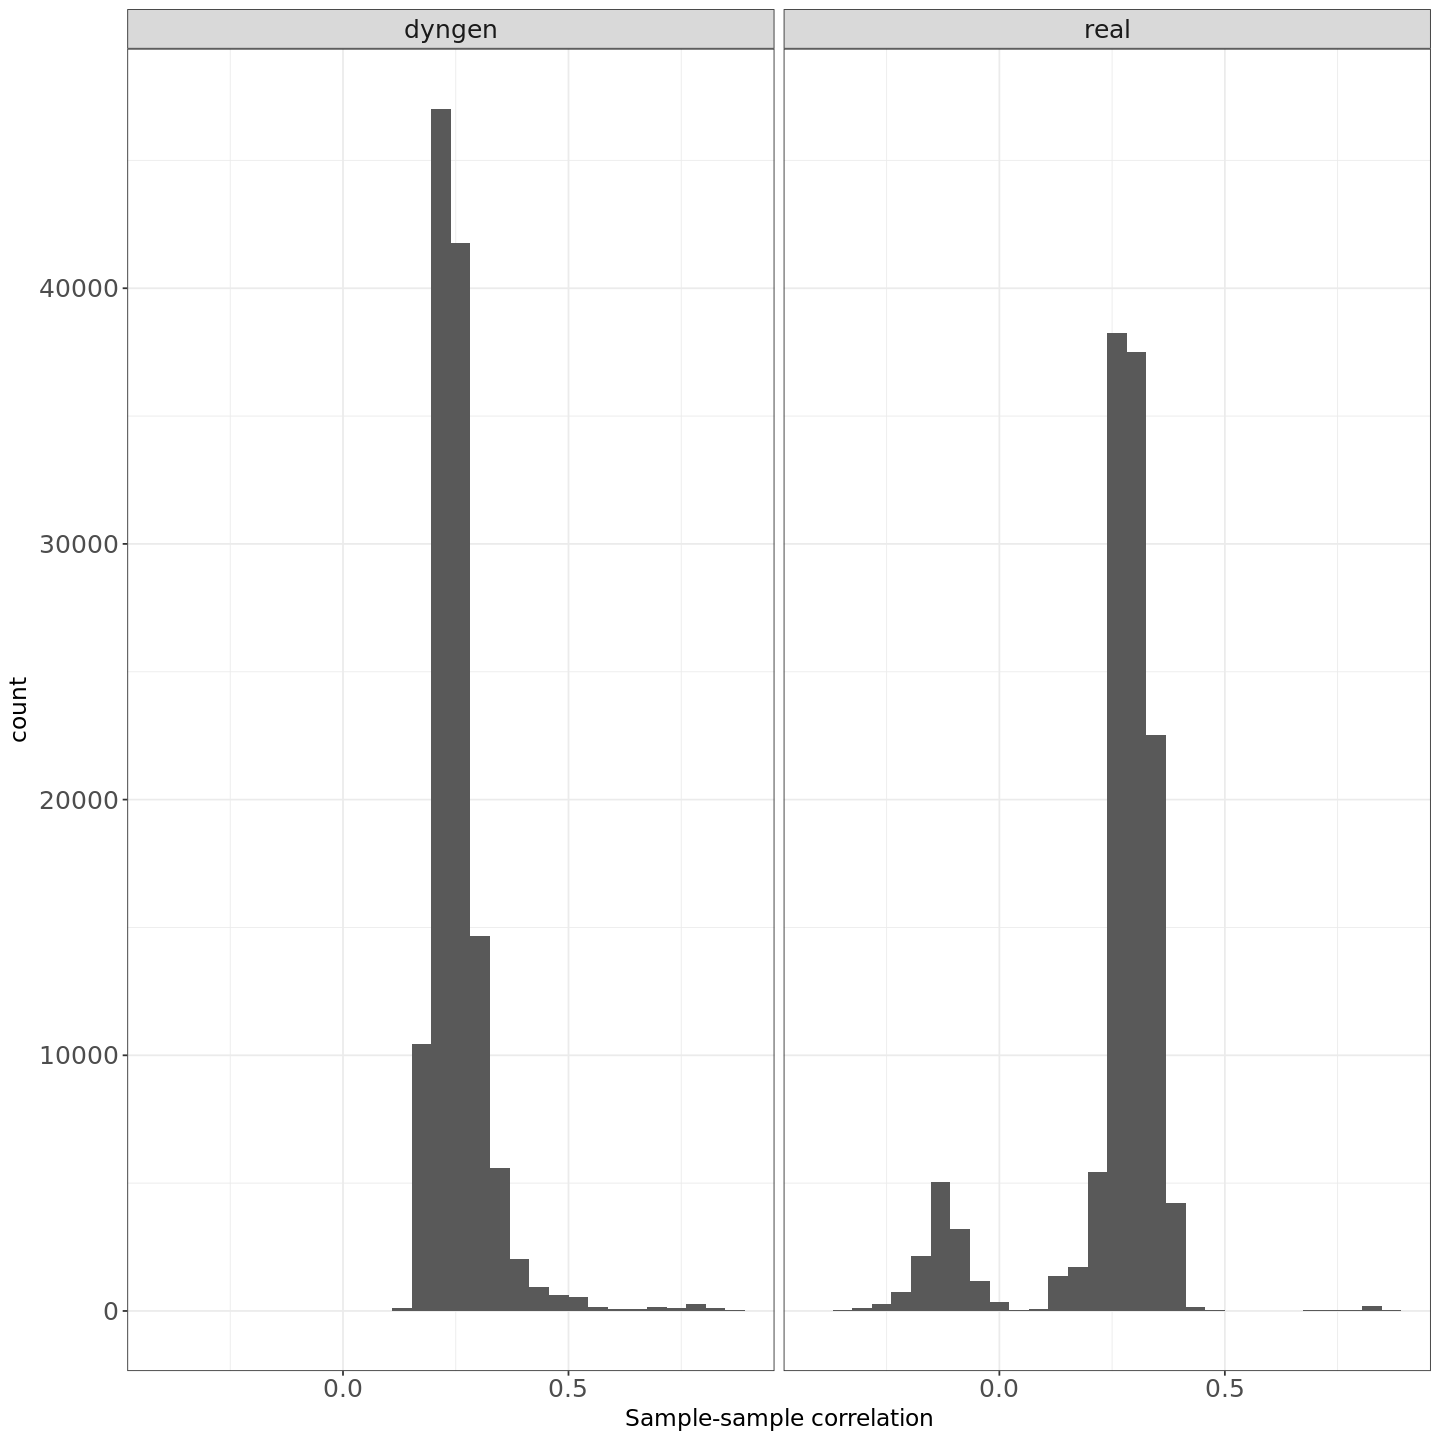

In [49]:
ggplot(sampleCorrDF, aes(x = Correlation)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Sample-sample correlation") + thm

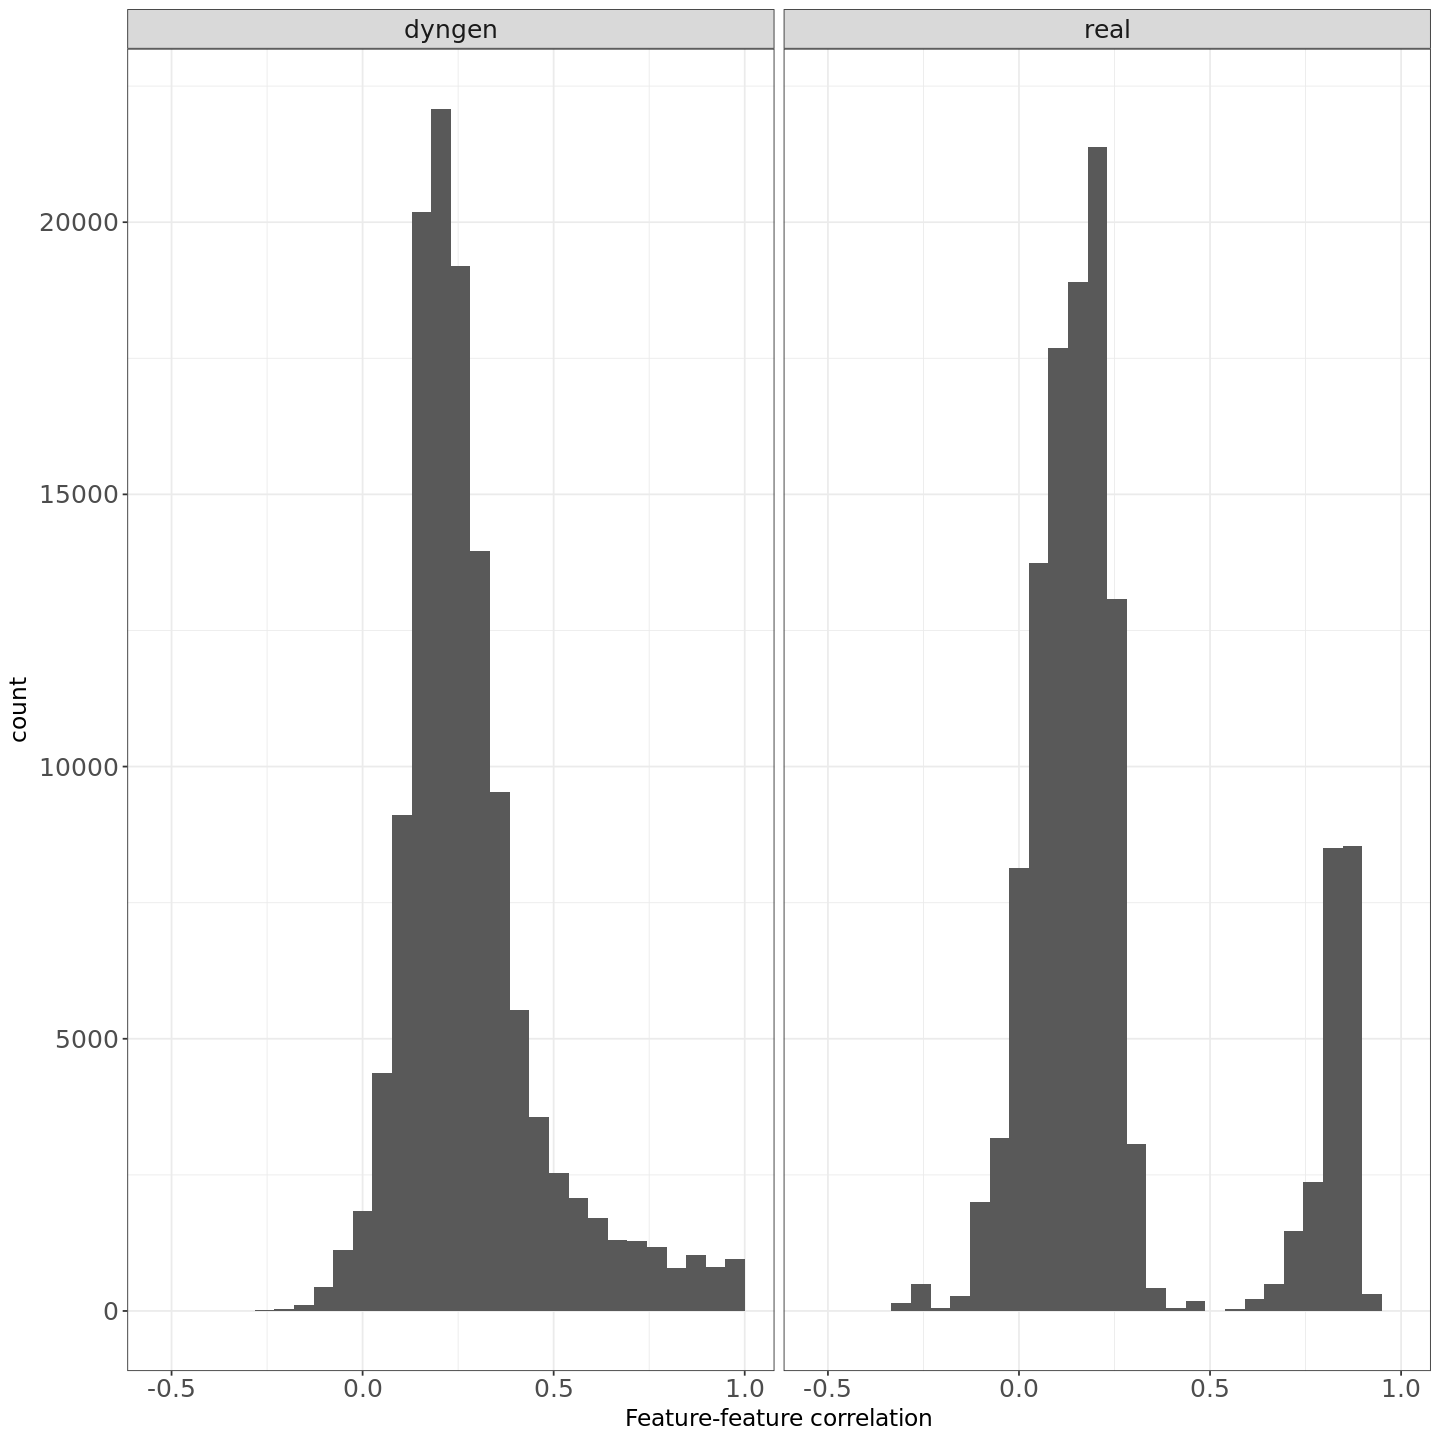

In [50]:
ggplot(featureCorrDF, aes(x = Correlation)) + geom_histogram(bins = 30) + 
  facet_wrap(~dataset, nrow = colRow[2]) +
  xlab("Feature-feature correlation") + thm

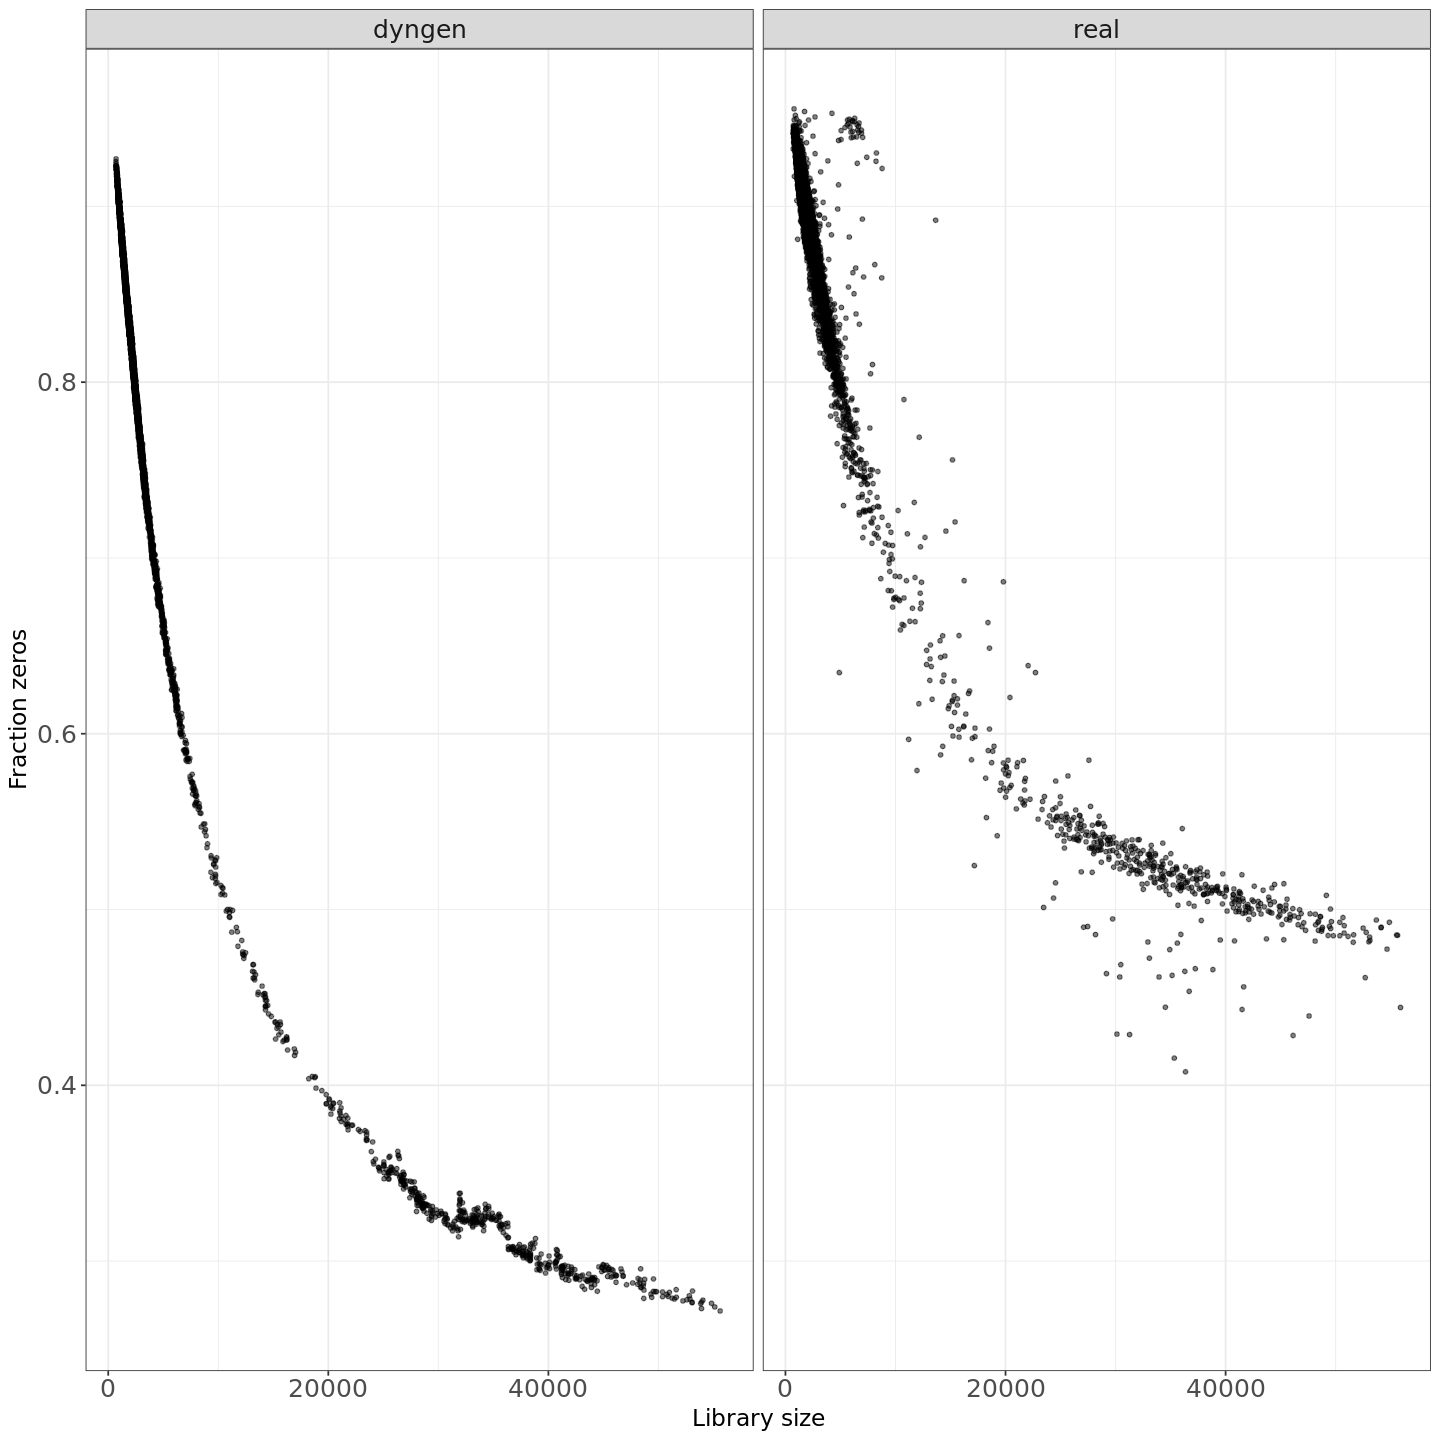

In [51]:
ggplot(sampleDF, aes(x = Libsize, y = Fraczero)) + 
  geom_point(size = 1, alpha = 0.5) + 
  facet_wrap(~dataset, nrow = colRow[2]) + 
  xlab("Library size") + ylab("Fraction zeros") + thm

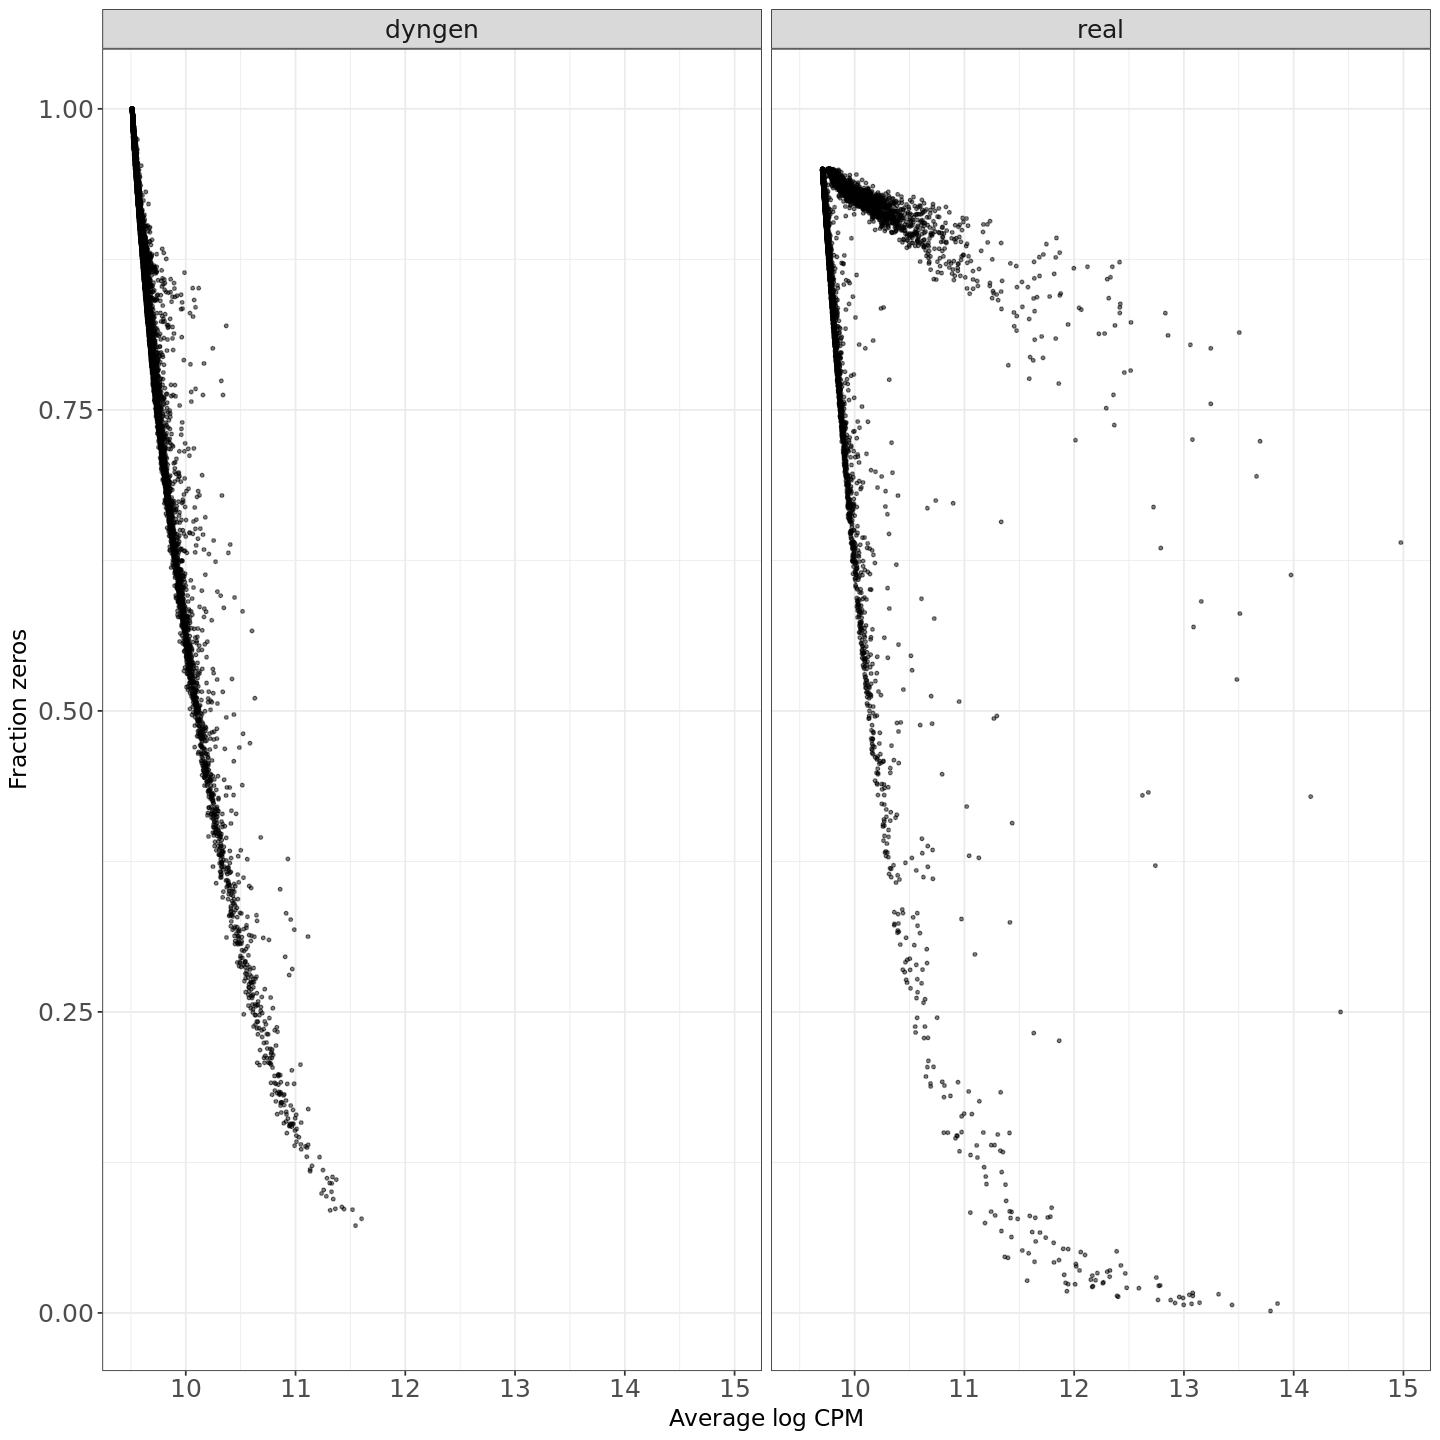

In [52]:
ggplot(featureDF, aes(x = AveLogCPM, y = Fraczero)) + 
  geom_point(size = 0.75, alpha = 0.5) + 
  facet_wrap(~dataset, nrow = colRow[2]) + 
  xlab("Average log CPM") + ylab("Fraction zeros") + thm